In [4]:
"""
ANÁLISIS DE INFORMACIÓN CREDITICIA - Home Credit Default Risk
============================================================

Objetivos:
- Aprender técnicas de análisis de información crediticia usando datos reales de Kaggle
- Dominar los fundamentos del análisis de datos
- Comprender cómo apoyar decisiones de negocio basadas en datos

Fuente de datos: Competencia Home Credit Default Risk
https://www.kaggle.com/competitions/home-credit-default-risk/
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy import stats
import subprocess
import sys

warnings.filterwarnings('ignore')

# Configuración de visualización
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_style("whitegrid")
sns.set_palette("husl")

print("="*80)
print("ANÁLISIS DE INFORMACIÓN CREDITICIA - HOME CREDIT DEFAULT RISK")
print("="*80)


ANÁLISIS DE INFORMACIÓN CREDITICIA - HOME CREDIT DEFAULT RISK


In [5]:
# ============================================================================
# 1. COMPRENSIÓN DEL CONTENIDO DE LA COMPETENCIA Y NEGOCIO
# ============================================================================

print("📊 1. COMPRENSIÓN DE LA COMPETENCIA")
print("="*40)

print("""
🏢 ACERCA DE HOME CREDIT:
─────────────────────────

🔹 Descripción de la empresa:
   • Home Credit es una empresa global de financiamiento al consumidor
   • Proporciona préstamos a clientes con historial bancario limitado
   • Opera en Europa del Este, Asia y América
   • Se enfoca en préstamos responsables

🎯 OBJETIVO DE LA COMPETENCIA:
   • Predecir el riesgo de incumplimiento de pago de los clientes
   • Lograr una evaluación crediticia más precisa
   • Promover la inclusión financiera (servir a más personas)

💼 BENEFICIOS COMERCIALES:
   • Mejora en la gestión de riesgos
   • Reducción de deudas incobrables
   • Expansión de préstamos a clientes adecuados
   • Mejora de la rentabilidad

📈 OBJETIVO DE PREDICCIÓN:
   • Variable TARGET (0: capacidad de pago, 1: riesgo de incumplimiento)
   • Problema de clasificación binaria
   • Métrica de evaluación: AUC (Área bajo la curva ROC)

🔍 CARACTERÍSTICAS DE LOS DATOS:
   • Información de solicitudes, información crediticia, historial de solicitudes
   • 307,511 registros de datos de entrenamiento
   • 122 características
   • Datos comerciales reales
""")

print("✅ Comprensión de la competencia completada")


📊 1. COMPRENSIÓN DE LA COMPETENCIA

🏢 ACERCA DE HOME CREDIT:
─────────────────────────

🔹 Descripción de la empresa:
   • Home Credit es una empresa global de financiamiento al consumidor
   • Proporciona préstamos a clientes con historial bancario limitado
   • Opera en Europa del Este, Asia y América
   • Se enfoca en préstamos responsables

🎯 OBJETIVO DE LA COMPETENCIA:
   • Predecir el riesgo de incumplimiento de pago de los clientes
   • Lograr una evaluación crediticia más precisa
   • Promover la inclusión financiera (servir a más personas)

💼 BENEFICIOS COMERCIALES:
   • Mejora en la gestión de riesgos
   • Reducción de deudas incobrables
   • Expansión de préstamos a clientes adecuados
   • Mejora de la rentabilidad

📈 OBJETIVO DE PREDICCIÓN:
   • Variable TARGET (0: capacidad de pago, 1: riesgo de incumplimiento)
   • Problema de clasificación binaria
   • Métrica de evaluación: AUC (Área bajo la curva ROC)

🔍 CARACTERÍSTICAS DE LOS DATOS:
   • Información de solicitudes, inf

In [6]:
# ============================================================================
# 2. CARGA DEL CONJUNTO DE DATOS E INFORMACIÓN BÁSICA (CORREGIDO)
# ============================================================================

print("\n📂 2. CARGA DEL CONJUNTO DE DATOS")
print("="*35)

# Función para instalar paquetes si no están disponibles
def instalar_paquete(nombre_paquete):
    """Instala un paquete de Python si no está disponible"""
    try:
        __import__(nombre_paquete)
        return True
    except ImportError:
        try:
            subprocess.check_call([sys.executable, "-m", "pip", "install", nombre_paquete, "--quiet"])
            return True
        except:
            return False

# Instalar chardet para detección de codificación
chardet_disponible = instalar_paquete('chardet')

# Carga del dataset principal
try:
    df_train = pd.read_csv('application_train.csv')
    print("✅ Carga exitosa de application_train.csv")
    print(f"   Forma de los datos: {df_train.shape}")
except FileNotFoundError:
    print("❌ No se encontró application_train.csv")
    print("   Verifica que el archivo esté en el mismo directorio que el notebook")
    exit()
except Exception as e:
    print(f"❌ Error al cargar application_train.csv: {e}")
    exit()

# Función para cargar CSV con múltiples codificaciones
def cargar_csv_con_multiples_codificaciones(nombre_archivo):
    """Intenta cargar un CSV con diferentes codificaciones comunes"""
    codificaciones = ['utf-8', 'latin-1', 'iso-8859-1', 'cp1252', 'utf-16']
    
    for codificacion in codificaciones:
        try:
            df = pd.read_csv(nombre_archivo, encoding=codificacion)
            print(f"✅ Archivo cargado exitosamente con codificación: {codificacion}")
            return df, codificacion
        except UnicodeDecodeError:
            print(f"⚠️ Fallo con codificación {codificacion}, probando siguiente...")
            continue
        except Exception as e:
            print(f"❌ Error con codificación {codificacion}: {e}")
            continue
    
    return None, None

# Función de diagnóstico de codificación
def diagnosticar_codificacion_archivo(ruta_archivo):
    """Diagnostica la codificación más probable de un archivo"""
    if chardet_disponible:
        try:
            import chardet
            with open(ruta_archivo, 'rb') as archivo:
                muestra = archivo.read(10000)
                resultado = chardet.detect(muestra)
            
            print(f"🔍 Codificación detectada: {resultado['encoding']} (confianza: {resultado['confidence']:.2%})")
            return resultado['encoding']
        except Exception as e:
            print(f"❌ Error en diagnóstico: {e}")
    return None

# Intentar cargar el archivo de descripción de columnas
print("\n📋 Cargando HomeCredit_columns_description.csv...")

# Diagnóstico de codificación
try:
    codificacion_sugerida = diagnosticar_codificacion_archivo('HomeCredit_columns_description.csv')
except:
    codificacion_sugerida = None

# Cargar archivo de descripción
df_description, codificacion_usada = cargar_csv_con_multiples_codificaciones('HomeCredit_columns_description.csv')

if df_description is not None:
    print("✅ Carga exitosa de HomeCredit_columns_description.csv")
    print(f"   Codificación utilizada: {codificacion_usada}")
    print(f"   Forma de datos de descripción: {df_description.shape}")
    print(f"   Columnas disponibles: {list(df_description.columns)}")
else:
    print("⚠️ No se pudo cargar el archivo de descripción")
    print("   El análisis continuará sin las descripciones de columnas")

# Función para crear descripciones básicas si no se puede cargar el archivo
def crear_descripciones_basicas(df):
    """Crea descripciones básicas basadas en los nombres de las columnas"""
    descripciones_conocidas = {
        'SK_ID_CURR': 'ID único de la solicitud actual',
        'TARGET': 'Variable objetivo (0: pago normal, 1: dificultades de pago)',
        'AMT_INCOME_TOTAL': 'Ingresos totales del cliente',
        'AMT_CREDIT': 'Monto del crédito solicitado',
        'AMT_ANNUITY': 'Monto de la anualidad del préstamo',
        'AMT_GOODS_PRICE': 'Precio de los bienes para los que se solicita el préstamo',
        'NAME_CONTRACT_TYPE': 'Tipo de contrato',
        'CODE_GENDER': 'Género del cliente',
        'FLAG_OWN_CAR': 'Indicador de si el cliente posee automóvil',
        'FLAG_OWN_REALTY': 'Indicador de si el cliente posee bienes raíces',
        'CNT_CHILDREN': 'Número de hijos del cliente',
        'NAME_INCOME_TYPE': 'Tipo de ingresos del cliente',
        'NAME_EDUCATION_TYPE': 'Nivel de educación del cliente',
        'NAME_FAMILY_STATUS': 'Estado civil del cliente',
        'NAME_HOUSING_TYPE': 'Tipo de vivienda del cliente',
        'DAYS_BIRTH': 'Edad del cliente en días (valor negativo)',
        'DAYS_EMPLOYED': 'Días que el cliente ha estado empleado (valor negativo)',
        'CNT_FAM_MEMBERS': 'Número de miembros de la familia del cliente',
        'REGION_RATING_CLIENT': 'Calificación de la región donde vive el cliente',
        'WEEKDAY_APPR_PROCESS_START': 'Día de la semana en que se inició el proceso de solicitud',
        'HOUR_APPR_PROCESS_START': 'Hora del día en que se inició el proceso de solicitud',
    }
    
    descripciones_df = []
    for col in df.columns:
        if col in descripciones_conocidas:
            descripcion = descripciones_conocidas[col]
        else:
            if col.startswith('AMT_'):
                descripcion = f"Monto relacionado con {col.replace('AMT_', '').lower()}"
            elif col.startswith('FLAG_'):
                descripcion = f"Indicador binario para {col.replace('FLAG_', '').lower()}"
            elif col.startswith('CNT_'):
                descripcion = f"Contador de {col.replace('CNT_', '').lower()}"
            elif col.startswith('NAME_'):
                descripcion = f"Nombre/tipo de {col.replace('NAME_', '').lower()}"
            elif col.startswith('DAYS_'):
                descripcion = f"Días relacionados con {col.replace('DAYS_', '').lower()}"
            else:
                descripcion = f"Información sobre {col.lower()}"
        
        descripciones_df.append({
            'Row': col,
            'Description': descripcion
        })
    
    return pd.DataFrame(descripciones_df)

# Si no se pudo cargar el archivo de descripción, crear uno básico
if df_description is None:
    print("\n🔄 Creando descripciones básicas de columnas...")
    df_description = crear_descripciones_basicas(df_train)
    print("✅ Descripciones básicas creadas")

# Mostrar información básica del dataset
print(f"\n📊 Información básica del conjunto de datos:")
print(f"   • Datos de solicitudes: {df_train.shape[0]:,} registros")
print(f"   • Número de características: {df_train.shape[1]:,}")
print(f"   • Uso de memoria: {df_train.memory_usage(deep=True).sum() / 1024**2:.1f} MB")

# Verificación de tipos de datos
caracteristicas_numericas = df_train.select_dtypes(include=[np.number]).columns
caracteristicas_categoricas = df_train.select_dtypes(include=['object']).columns

print(f"   • Características numéricas: {len(caracteristicas_numericas)}")
print(f"   • Características categóricas: {len(caracteristicas_categoricas)}")

print("\n✅ Carga de datos completada")



📂 2. CARGA DEL CONJUNTO DE DATOS
✅ Carga exitosa de application_train.csv
   Forma de los datos: (307511, 122)

📋 Cargando HomeCredit_columns_description.csv...
🔍 Codificación detectada: Windows-1252 (confianza: 73.00%)
⚠️ Fallo con codificación utf-8, probando siguiente...
✅ Archivo cargado exitosamente con codificación: latin-1
✅ Carga exitosa de HomeCredit_columns_description.csv
   Codificación utilizada: latin-1
   Forma de datos de descripción: (219, 5)
   Columnas disponibles: ['Unnamed: 0', 'Table', 'Row', 'Description', 'Special']

📊 Información básica del conjunto de datos:
   • Datos de solicitudes: 307,511 registros
   • Número de características: 122
   • Uso de memoria: 536.7 MB
   • Características numéricas: 106
   • Características categóricas: 16

✅ Carga de datos completada


In [7]:
# ============================================================================
# 3. COMPRENSIÓN GENERAL DE LOS DATOS
# ============================================================================

print("\n🔍 3. COMPRENSIÓN GENERAL DE LOS DATOS")
print("="*40)

print("📋 Primeras 5 filas:")
print("-"*20)
display(df_train.head())

print(f"\n📊 Información de tipos de datos y valores faltantes:")
print("-"*50)
print(df_train.info())

print(f"\n📈 Características estadísticas de datos numéricos:")
print("-"*45)
display(df_train.describe())

# Distribución de la variable objetivo
print(f"\n🎯 Distribución de la variable objetivo (TARGET):")
print("-"*45)
conteos_target = df_train['TARGET'].value_counts()
porcentajes_target = df_train['TARGET'].value_counts(normalize=True) * 100

for valor, conteo in conteos_target.items():
    porcentaje = porcentajes_target[valor]
    estado = "Capacidad de pago" if valor == 0 else "Riesgo de incumplimiento"
    print(f"   • {valor} ({estado}): {conteo:,} registros ({porcentaje:.2f}%)")

# Verificación de datos desbalanceados
ratio_desbalance = conteos_target[0] / conteos_target[1]
print(f"   • Ratio de desbalance de datos: {ratio_desbalance:.1f}:1")
print("   • ⚠️ Debido a datos desbalanceados, se necesitan métricas de evaluación apropiadas")

print("\n✅ Comprensión general completada")



🔍 3. COMPRENSIÓN GENERAL DE LOS DATOS
📋 Primeras 5 filas:
--------------------


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0



📊 Información de tipos de datos y valores faltantes:
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB
None

📈 Características estadísticas de datos numéricos:
---------------------------------------------


,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,...,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,...,0.008130,0.000595,0.000507,0.000335,0.006402,0.007000,0.034362,0.267395,0.265474,1.899974
std,102790.175348,0.272419,0.722121,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.013831,4363.988632,141275.766519,...,0.089798,0.024387,0.022518,0.018299,0.083849,0.110757,0.204685,0.916002,0.794056,1.869295
min,100002.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25229.000000,-17912.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189145.500000,0.000000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010006,-19682.000000,-2760.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278202.000000,0.000000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.018850,-15750.000000,-1213.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,367142.500000,0.000000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.028663,-12413.000000,-289.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,456255.000000,1.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,-7489.000000,365243.000000,...,1.000000,1.000000,1.000000,1.000000,4.000000,9.000000,8.000000,27.000000,261.000000,25.000000



🎯 Distribución de la variable objetivo (TARGET):
---------------------------------------------
   • 0 (Capacidad de pago): 282,686 registros (91.93%)
   • 1 (Riesgo de incumplimiento): 24,825 registros (8.07%)
   • Ratio de desbalance de datos: 11.4:1
   • ⚠️ Debido a datos desbalanceados, se necesitan métricas de evaluación apropiadas

✅ Comprensión general completada



🕳️ 4. ANÁLISIS DETALLADO DE VALORES FALTANTES
📊 Características con valores faltantes: 67
Total de valores faltantes: 9,152,465

📈 Top 20 de valores faltantes:


,Característica,Cantidad_Faltante,Porcentaje(%)
0,COMMONAREA_MEDI,214865,69.872297
1,COMMONAREA_AVG,214865,69.872297
2,COMMONAREA_MODE,214865,69.872297
3,NONLIVINGAPARTMENTS_MODE,213514,69.432963
4,NONLIVINGAPARTMENTS_AVG,213514,69.432963
5,NONLIVINGAPARTMENTS_MEDI,213514,69.432963
6,FONDKAPREMONT_MODE,210295,68.386172
7,LIVINGAPARTMENTS_MODE,210199,68.354953
8,LIVINGAPARTMENTS_AVG,210199,68.354953
9,LIVINGAPARTMENTS_MEDI,210199,68.354953


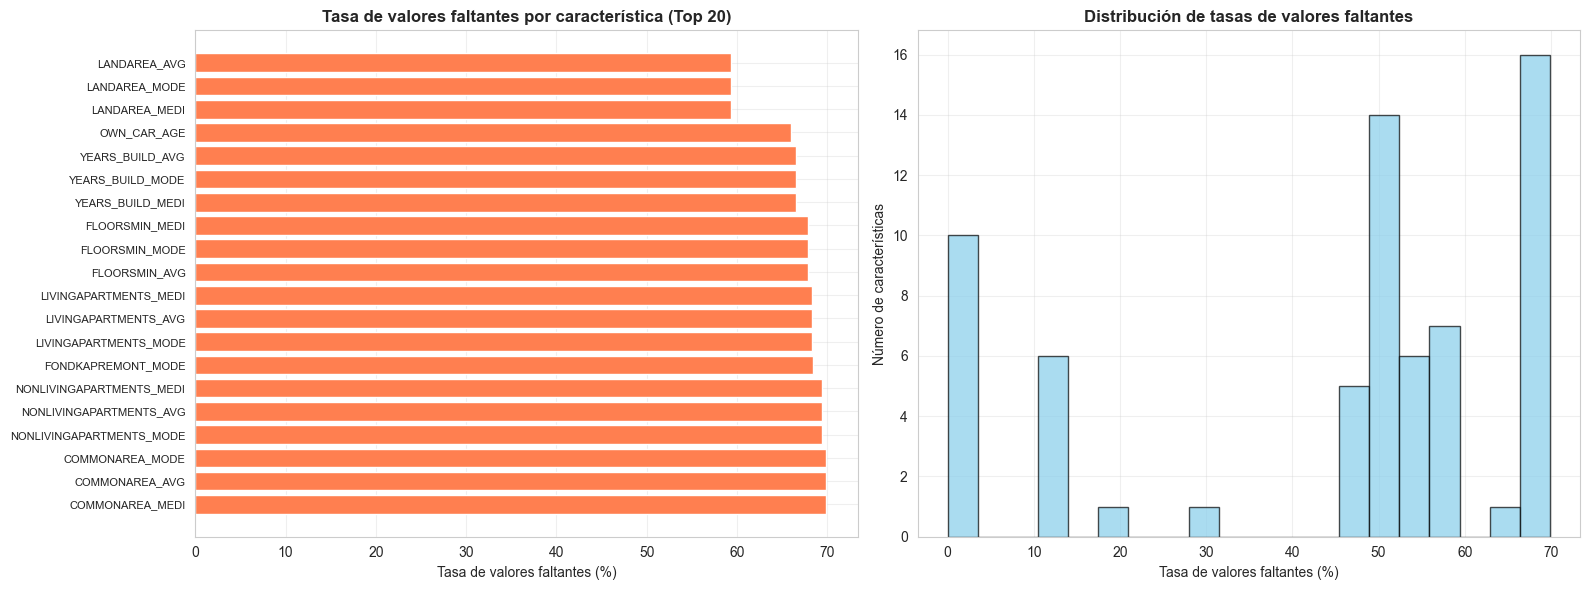


📊 Clasificación por tasa de faltantes:
   • Faltantes altos (>50%): 41 características
   • Faltantes medios (10-50%): 16 características
   • Faltantes bajos (≤10%): 10 características

✅ Análisis de valores faltantes completado


In [8]:
# ============================================================================
# 4. ANÁLISIS DE VALORES FALTANTES
# ============================================================================

print("\n🕳️ 4. ANÁLISIS DETALLADO DE VALORES FALTANTES")
print("="*45)

# Resumen de valores faltantes
datos_faltantes = df_train.isnull().sum().sort_values(ascending=False)
datos_faltantes = datos_faltantes[datos_faltantes > 0]

if len(datos_faltantes) > 0:
    print(f"📊 Características con valores faltantes: {len(datos_faltantes)}")
    print(f"Total de valores faltantes: {datos_faltantes.sum():,}")
    
    # Cálculo de tasas de valores faltantes
    porcentaje_faltantes = (datos_faltantes / len(df_train)) * 100
    df_faltantes = pd.DataFrame({
        'Característica': datos_faltantes.index,
        'Cantidad_Faltante': datos_faltantes.values,
        'Porcentaje(%)': porcentaje_faltantes.values
    })
    
    print(f"\n📈 Top 20 de valores faltantes:")
    display(df_faltantes.head(20))
    
    # Visualización de valores faltantes
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Gráfico de barras de tasas de faltantes (top 20)
    top_faltantes = porcentaje_faltantes.head(20)
    ax1.barh(range(len(top_faltantes)), top_faltantes.values, color='coral')
    ax1.set_yticks(range(len(top_faltantes)))
    ax1.set_yticklabels(top_faltantes.index, fontsize=8)
    ax1.set_xlabel('Tasa de valores faltantes (%)')
    ax1.set_title('Tasa de valores faltantes por característica (Top 20)', fontweight='bold')
    ax1.grid(True, alpha=0.3)
    
    # Distribución de tasas de faltantes
    ax2.hist(porcentaje_faltantes.values, bins=20, color='skyblue', alpha=0.7, edgecolor='black')
    ax2.set_xlabel('Tasa de valores faltantes (%)')
    ax2.set_ylabel('Número de características')
    ax2.set_title('Distribución de tasas de valores faltantes', fontweight='bold')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Análisis de patrones de faltantes
    faltantes_altos = porcentaje_faltantes[porcentaje_faltantes > 50].index
    faltantes_medios = porcentaje_faltantes[(porcentaje_faltantes > 10) & (porcentaje_faltantes <= 50)].index
    faltantes_bajos = porcentaje_faltantes[porcentaje_faltantes <= 10].index
    
    print(f"\n📊 Clasificación por tasa de faltantes:")
    print(f"   • Faltantes altos (>50%): {len(faltantes_altos)} características")
    print(f"   • Faltantes medios (10-50%): {len(faltantes_medios)} características") 
    print(f"   • Faltantes bajos (≤10%): {len(faltantes_bajos)} características")
    
else:
    print("✅ No se encontraron valores faltantes")

print("\n✅ Análisis de valores faltantes completado")



🎯 5. ANÁLISIS DETALLADO DE LA VARIABLE OBJETIVO


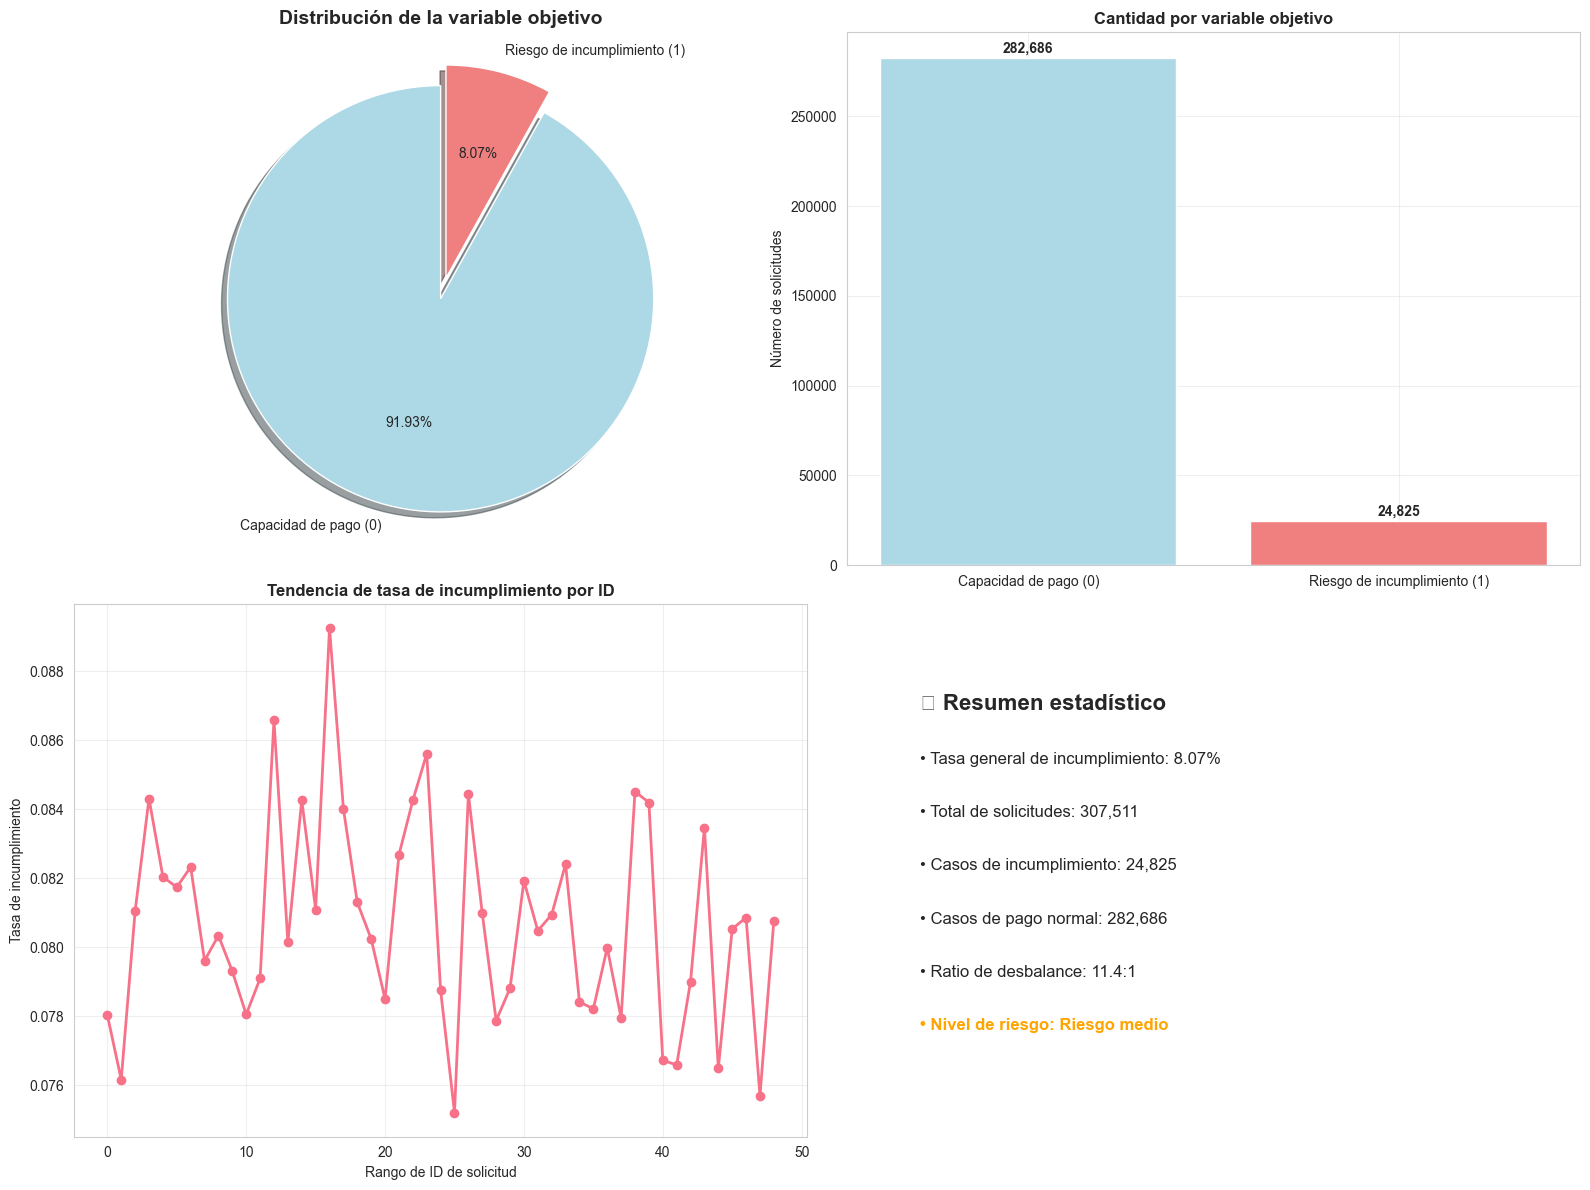

📈 Resultados del análisis de variable objetivo:
   • Tasa de incumplimiento: 8.07%
   • Nivel de riesgo: Riesgo medio
   • Balance de datos: Datos desbalanceados (11.4:1)

✅ Análisis de variable objetivo completado


In [9]:
# ============================================================================
# 5. ANÁLISIS DETALLADO DE LA VARIABLE OBJETIVO
# ============================================================================

print("\n🎯 5. ANÁLISIS DETALLADO DE LA VARIABLE OBJETIVO")
print("="*48)

# Visualización de la variable objetivo
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Gráfico circular
conteos_target = df_train['TARGET'].value_counts()
etiquetas = ['Capacidad de pago (0)', 'Riesgo de incumplimiento (1)']
colores = ['lightblue', 'lightcoral']
explosion = (0, 0.1)

ax1.pie(conteos_target.values, labels=etiquetas, colors=colores, autopct='%1.2f%%', 
        startangle=90, explode=explosion, shadow=True)
ax1.set_title('Distribución de la variable objetivo', fontweight='bold', fontsize=14)

# Gráfico de barras
ax2.bar(range(len(conteos_target)), conteos_target.values, color=colores)
ax2.set_xticks(range(len(conteos_target)))
ax2.set_xticklabels(['Capacidad de pago (0)', 'Riesgo de incumplimiento (1)'])
ax2.set_ylabel('Número de solicitudes')
ax2.set_title('Cantidad por variable objetivo', fontweight='bold')
ax2.grid(True, alpha=0.3)

# Agregar anotaciones de valores
for i, v in enumerate(conteos_target.values):
    ax2.text(i, v + 1000, f'{v:,}', ha='center', va='bottom', fontweight='bold')

# Tendencia temporal (usando SK_ID_CURR como proxy)
ids_muestra = np.linspace(df_train['SK_ID_CURR'].min(), df_train['SK_ID_CURR'].max(), 50)
tendencia_target = []
for i in range(len(ids_muestra)-1):
    mascara = (df_train['SK_ID_CURR'] >= ids_muestra[i]) & (df_train['SK_ID_CURR'] < ids_muestra[i+1])
    if mascara.sum() > 0:
        tasa_target = df_train[mascara]['TARGET'].mean()
        tendencia_target.append(tasa_target)

if len(tendencia_target) > 0:
    ax3.plot(range(len(tendencia_target)), tendencia_target, marker='o', linewidth=2)
    ax3.set_xlabel('Rango de ID de solicitud')
    ax3.set_ylabel('Tasa de incumplimiento')
    ax3.set_title('Tendencia de tasa de incumplimiento por ID', fontweight='bold')
    ax3.grid(True, alpha=0.3)

# Información estadística
tasa_incumplimiento_general = df_train['TARGET'].mean() * 100
ax4.text(0.1, 0.8, f'📊 Resumen estadístico', fontsize=16, fontweight='bold', transform=ax4.transAxes)
ax4.text(0.1, 0.7, f'• Tasa general de incumplimiento: {tasa_incumplimiento_general:.2f}%', fontsize=12, transform=ax4.transAxes)
ax4.text(0.1, 0.6, f'• Total de solicitudes: {len(df_train):,}', fontsize=12, transform=ax4.transAxes)
ax4.text(0.1, 0.5, f'• Casos de incumplimiento: {conteos_target[1]:,}', fontsize=12, transform=ax4.transAxes)
ax4.text(0.1, 0.4, f'• Casos de pago normal: {conteos_target[0]:,}', fontsize=12, transform=ax4.transAxes)
ax4.text(0.1, 0.3, f'• Ratio de desbalance: {conteos_target[0]/conteos_target[1]:.1f}:1', fontsize=12, transform=ax4.transAxes)

# Clasificación de nivel de riesgo
if tasa_incumplimiento_general < 5:
    nivel_riesgo = "Riesgo bajo"
    color_riesgo = "green"
elif tasa_incumplimiento_general < 15:
    nivel_riesgo = "Riesgo medio"
    color_riesgo = "orange"
else:
    nivel_riesgo = "Riesgo alto" 
    color_riesgo = "red"

ax4.text(0.1, 0.2, f'• Nivel de riesgo: {nivel_riesgo}', fontsize=12, color=color_riesgo, 
         fontweight='bold', transform=ax4.transAxes)

ax4.set_xlim(0, 1)
ax4.set_ylim(0, 1)
ax4.axis('off')

plt.tight_layout()
plt.show()

print(f"📈 Resultados del análisis de variable objetivo:")
print(f"   • Tasa de incumplimiento: {tasa_incumplimiento_general:.2f}%")
print(f"   • Nivel de riesgo: {nivel_riesgo}")
print(f"   • Balance de datos: Datos desbalanceados ({conteos_target[0]/conteos_target[1]:.1f}:1)")

print("\n✅ Análisis de variable objetivo completado")


In [10]:
# ============================================================================
# 6. ESTABLECIMIENTO DE PROBLEMAS E HIPÓTESIS
# ============================================================================

print("\n❓ 6. ESTABLECIMIENTO DE PROBLEMAS E HIPÓTESIS")
print("="*48)

print("""
🎯 CONFIGURACIÓN DE PROBLEMAS DE ANÁLISIS:
──────────────────────────────────────────

1️⃣ INFLUENCIA DE FACTORES DEMOGRÁFICOS:
   ❓ ¿Influyen la edad, sexo y composición familiar en el riesgo de incumplimiento?
   💭 Hipótesis: Jóvenes y familias con muchos dependientes pueden tener mayor riesgo

2️⃣ FACTORES RELACIONADOS CON INGRESOS Y EMPLEO:
   ❓ ¿Cómo se relacionan el monto de ingresos, fuente de ingresos y tipo de empleo con el riesgo?
   💭 Hipótesis: Bajos ingresos y empleo inestable aumentan el riesgo

3️⃣ INFLUENCIA DE CONDICIONES DE PRÉSTAMO:
   ❓ ¿Influyen el monto del préstamo, tasa de interés y período de pago en el riesgo?
   💭 Hipótesis: Préstamos de alto monto y alta tasa de interés dificultan el pago

4️⃣ INFORMACIÓN CREDITICIA EXTERNA:
   ❓ ¿Son efectivos la evaluación crediticia externa y el historial financiero pasado?
   💭 Hipótesis: Historial de morosidad y baja calificación crediticia aumentan el riesgo

5️⃣ PATRONES DE COMPORTAMIENTO DE SOLICITUD:
   ❓ ¿Hay características en el día de la semana, hora y método de solicitud?
   💭 Hipótesis: Ciertos patrones de solicitud pueden cambiar el riesgo

6️⃣ FACTORES REGIONALES Y SOCIOECONÓMICOS:
   ❓ ¿Se relaciona la situación socioeconómica de la región con el riesgo?
   💭 Hipótesis: Regiones con mala situación económica pueden tener mayor riesgo
""")

print("✅ Establecimiento de problemas completado")



❓ 6. ESTABLECIMIENTO DE PROBLEMAS E HIPÓTESIS

🎯 CONFIGURACIÓN DE PROBLEMAS DE ANÁLISIS:
──────────────────────────────────────────

1️⃣ INFLUENCIA DE FACTORES DEMOGRÁFICOS:
   ❓ ¿Influyen la edad, sexo y composición familiar en el riesgo de incumplimiento?
   💭 Hipótesis: Jóvenes y familias con muchos dependientes pueden tener mayor riesgo

2️⃣ FACTORES RELACIONADOS CON INGRESOS Y EMPLEO:
   ❓ ¿Cómo se relacionan el monto de ingresos, fuente de ingresos y tipo de empleo con el riesgo?
   💭 Hipótesis: Bajos ingresos y empleo inestable aumentan el riesgo

3️⃣ INFLUENCIA DE CONDICIONES DE PRÉSTAMO:
   ❓ ¿Influyen el monto del préstamo, tasa de interés y período de pago en el riesgo?
   💭 Hipótesis: Préstamos de alto monto y alta tasa de interés dificultan el pago

4️⃣ INFORMACIÓN CREDITICIA EXTERNA:
   ❓ ¿Son efectivos la evaluación crediticia externa y el historial financiero pasado?
   💭 Hipótesis: Historial de morosidad y baja calificación crediticia aumentan el riesgo

5️⃣ PATRONES 


📊 7. ANÁLISIS EXPLORATORIO DE CARACTERÍSTICAS PRINCIPALES
Características objetivo de análisis: 8
Características: ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'CNT_CHILDREN', 'CNT_FAM_MEMBERS']

💰 Análisis de ingresos:
--------------------


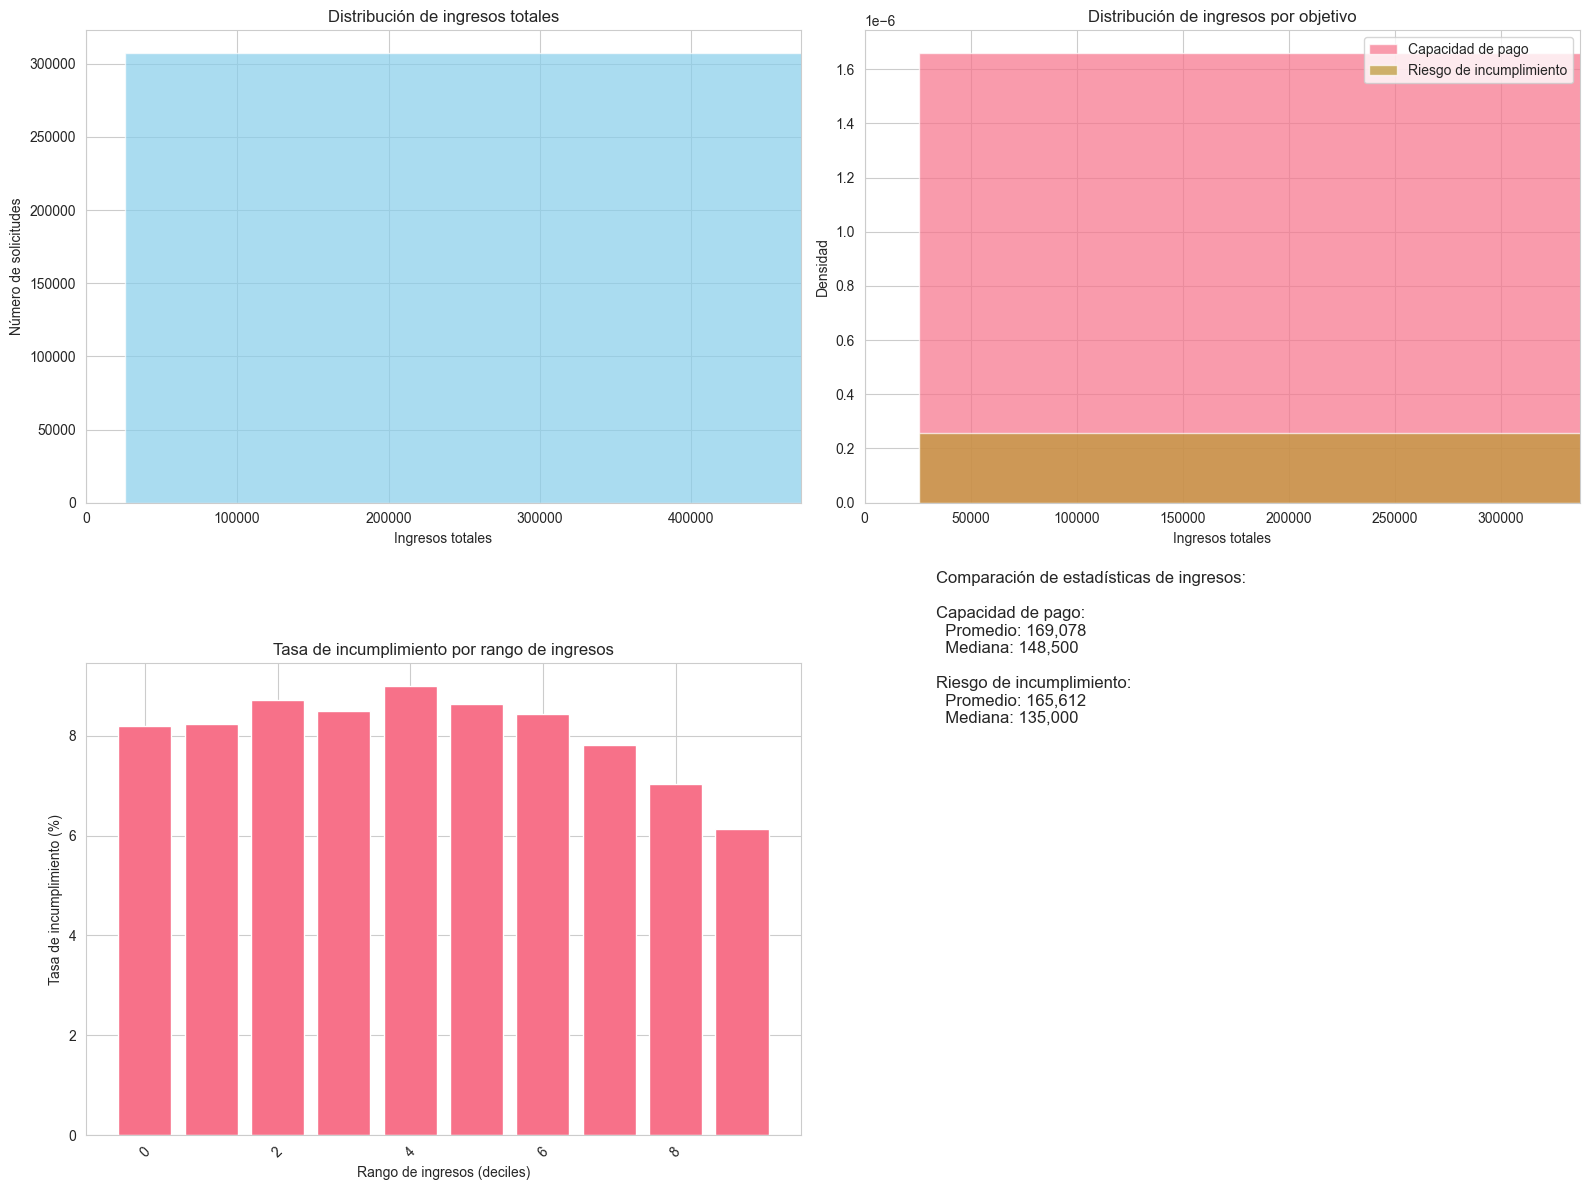


👥 Análisis de edad:
---------------


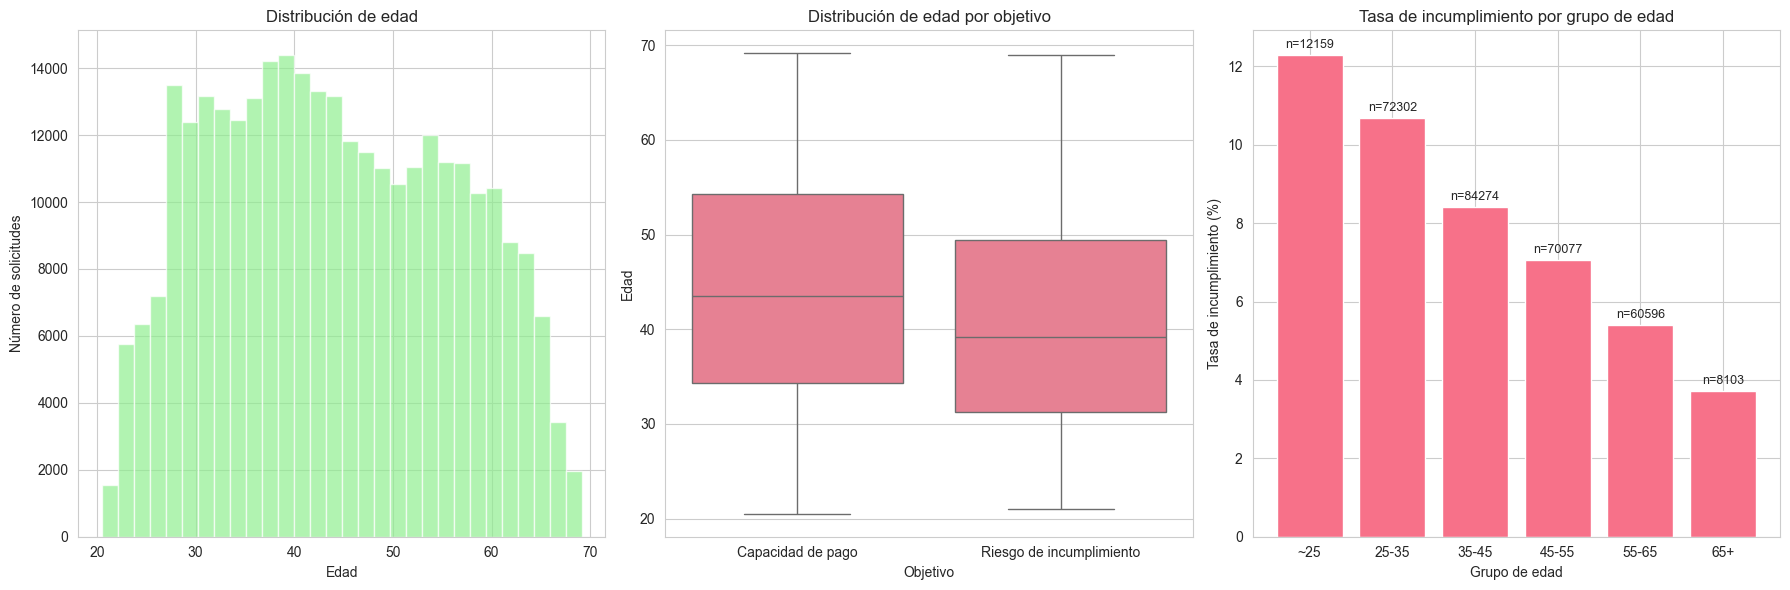


💳 Análisis de monto de préstamo:
------------------------------


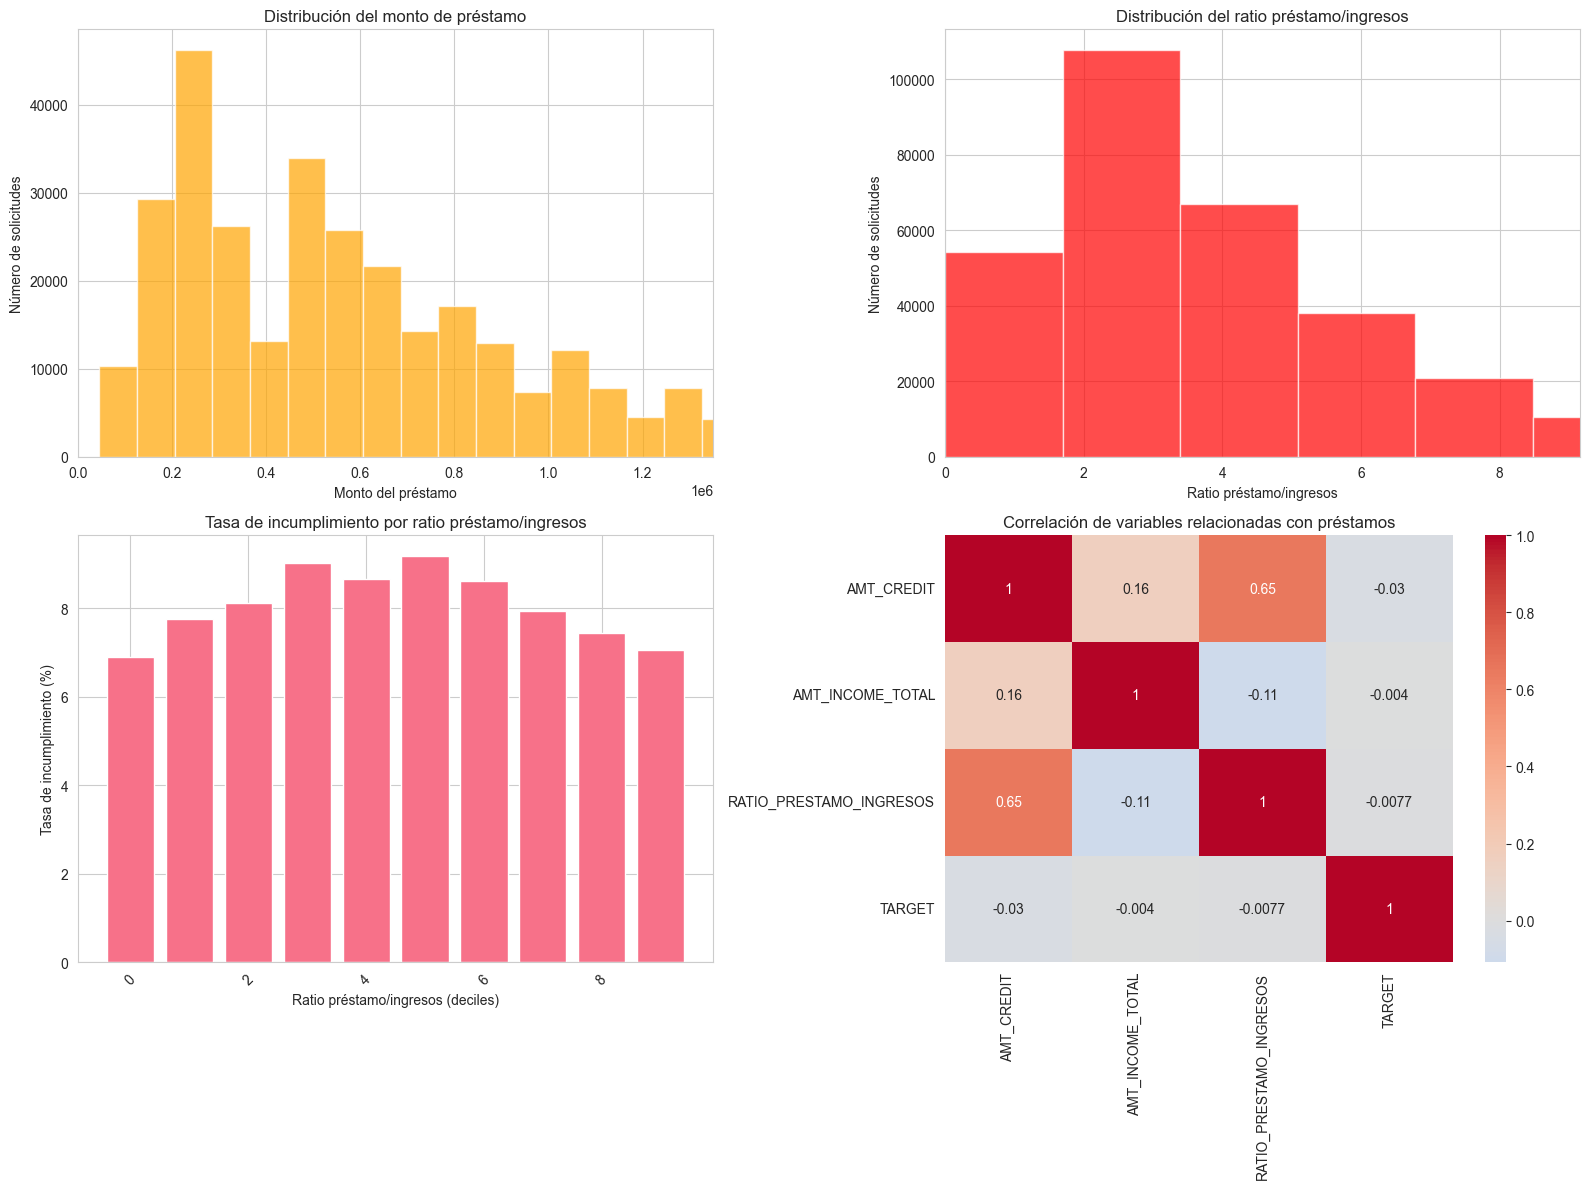


✅ Análisis de características principales completado


In [11]:
# ============================================================================
# 7. ANÁLISIS EXPLORATORIO DE CARACTERÍSTICAS PRINCIPALES (EDA)
# ============================================================================

print("\n📊 7. ANÁLISIS EXPLORATORIO DE CARACTERÍSTICAS PRINCIPALES")
print("="*55)

# Selección de características importantes
caracteristicas_clave = [
    'AMT_INCOME_TOTAL',    # Ingresos totales
    'AMT_CREDIT',          # Monto del préstamo
    'AMT_ANNUITY',         # Monto de anualidad/pago a plazos
    'AMT_GOODS_PRICE',     # Precio del producto
    'DAYS_BIRTH',          # Fecha de nacimiento (valor negativo)
    'DAYS_EMPLOYED',       # Días de empleo (valor negativo)
    'CNT_CHILDREN',        # Número de hijos
    'CNT_FAM_MEMBERS',     # Número de miembros de la familia
]

# Verificar qué características existen
caracteristicas_disponibles = [f for f in caracteristicas_clave if f in df_train.columns]
print(f"Características objetivo de análisis: {len(caracteristicas_disponibles)}")
print(f"Características: {caracteristicas_disponibles}")

if len(caracteristicas_disponibles) > 0:
    # Conversión de edad y años de empleo a valores positivos
    df_analisis = df_train.copy()
    
    if 'DAYS_BIRTH' in df_analisis.columns:
        df_analisis['EDAD'] = -df_analisis['DAYS_BIRTH'] / 365
    
    if 'DAYS_EMPLOYED' in df_analisis.columns:
        # Tratamiento de valores anómalos (365243 es un valor especial que indica desempleo)
        df_analisis['AÑOS_EMPLEO'] = df_analisis['DAYS_EMPLOYED'].apply(
            lambda x: -x / 365 if x != 365243 else 0
        )

    # 1. Análisis de ingresos
    print("\n💰 Análisis de ingresos:")
    print("-" * 20)
    
    if 'AMT_INCOME_TOTAL' in df_analisis.columns:
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        
        # Distribución de ingresos
        axes[0,0].hist(df_analisis['AMT_INCOME_TOTAL'], bins=50, alpha=0.7, color='skyblue')
        axes[0,0].set_xlabel('Ingresos totales')
        axes[0,0].set_ylabel('Número de solicitudes')
        axes[0,0].set_title('Distribución de ingresos totales')
        axes[0,0].set_xlim(0, df_analisis['AMT_INCOME_TOTAL'].quantile(0.99))
        
        # Distribución de ingresos por objetivo
        for target in [0, 1]:
            datos = df_analisis[df_analisis['TARGET'] == target]['AMT_INCOME_TOTAL']
            etiqueta = 'Capacidad de pago' if target == 0 else 'Riesgo de incumplimiento'
            axes[0,1].hist(datos, bins=30, alpha=0.7, label=etiqueta, density=True)
        
        axes[0,1].set_xlabel('Ingresos totales')
        axes[0,1].set_ylabel('Densidad')
        axes[0,1].set_title('Distribución de ingresos por objetivo')
        axes[0,1].legend()
        axes[0,1].set_xlim(0, df_analisis['AMT_INCOME_TOTAL'].quantile(0.95))
        
        # Tasa de incumplimiento por rango de ingresos
        rangos_ingresos = pd.qcut(df_analisis['AMT_INCOME_TOTAL'], q=10, duplicates='drop')
        incumplimiento_por_ingresos = df_analisis.groupby(rangos_ingresos)['TARGET'].agg(['mean', 'count'])
        
        axes[1,0].bar(range(len(incumplimiento_por_ingresos)), incumplimiento_por_ingresos['mean'] * 100)
        axes[1,0].set_xlabel('Rango de ingresos (deciles)')
        axes[1,0].set_ylabel('Tasa de incumplimiento (%)')
        axes[1,0].set_title('Tasa de incumplimiento por rango de ingresos')
        axes[1,0].tick_params(axis='x', rotation=45)
        
        # Estadísticas de ingresos
        estadisticas_ingresos = df_analisis.groupby('TARGET')['AMT_INCOME_TOTAL'].describe()
        axes[1,1].axis('off')
        
        texto_estadisticas = "Comparación de estadísticas de ingresos:\n\n"
        for target in [0, 1]:
            etiqueta = "Capacidad de pago" if target == 0 else "Riesgo de incumplimiento"
            ingresos_promedio = estadisticas_ingresos.loc[target, 'mean']
            ingresos_mediana = estadisticas_ingresos.loc[target, '50%']
            texto_estadisticas += f"{etiqueta}:\n"
            texto_estadisticas += f"  Promedio: {ingresos_promedio:,.0f}\n"
            texto_estadisticas += f"  Mediana: {ingresos_mediana:,.0f}\n\n"
        
        axes[1,1].text(0.1, 0.8, texto_estadisticas, fontsize=12, transform=axes[1,1].transAxes)
        
        plt.tight_layout()
        plt.show()

    # 2. Análisis de edad
    print("\n👥 Análisis de edad:")
    print("-" * 15)
    
    if 'EDAD' in df_analisis.columns:
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        
        # Distribución de edad
        axes[0].hist(df_analisis['EDAD'], bins=30, alpha=0.7, color='lightgreen')
        axes[0].set_xlabel('Edad')
        axes[0].set_ylabel('Número de solicitudes')
        axes[0].set_title('Distribución de edad')
        
        # Distribución de edad por objetivo
        sns.boxplot(data=df_analisis, x='TARGET', y='EDAD', ax=axes[1])
        axes[1].set_xlabel('Objetivo')
        axes[1].set_ylabel('Edad')
        axes[1].set_title('Distribución de edad por objetivo')
        axes[1].set_xticklabels(['Capacidad de pago', 'Riesgo de incumplimiento'])
        
        # Tasa de incumplimiento por grupo de edad
        grupos_edad = pd.cut(df_analisis['EDAD'], bins=[0, 25, 35, 45, 55, 65, 100], 
                           labels=['~25', '25-35', '35-45', '45-55', '55-65', '65+'])
        incumplimiento_por_edad = df_analisis.groupby(grupos_edad)['TARGET'].agg(['mean', 'count'])
        
        barras = axes[2].bar(range(len(incumplimiento_por_edad)), incumplimiento_por_edad['mean'] * 100)
        axes[2].set_xlabel('Grupo de edad')
        axes[2].set_ylabel('Tasa de incumplimiento (%)')
        axes[2].set_title('Tasa de incumplimiento por grupo de edad')
        axes[2].set_xticks(range(len(incumplimiento_por_edad)))
        axes[2].set_xticklabels(incumplimiento_por_edad.index)
        
        # Mostrar número de casos en cada barra
        for i, (barra, conteo) in enumerate(zip(barras, incumplimiento_por_edad['count'])):
            axes[2].text(barra.get_x() + barra.get_width()/2, barra.get_height() + 0.1,
                        f'n={conteo}', ha='center', va='bottom', fontsize=9)
        
        plt.tight_layout()
        plt.show()

    # 3. Análisis de monto de préstamo
    print("\n💳 Análisis de monto de préstamo:")
    print("-" * 30)
    
    if 'AMT_CREDIT' in df_analisis.columns and 'AMT_INCOME_TOTAL' in df_analisis.columns:
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        
        # Distribución de monto de préstamo
        axes[0,0].hist(df_analisis['AMT_CREDIT'], bins=50, alpha=0.7, color='orange')
        axes[0,0].set_xlabel('Monto del préstamo')
        axes[0,0].set_ylabel('Número de solicitudes')
        axes[0,0].set_title('Distribución del monto de préstamo')
        axes[0,0].set_xlim(0, df_analisis['AMT_CREDIT'].quantile(0.95))
        
        # Ratio préstamo/ingresos
        df_analisis['RATIO_PRESTAMO_INGRESOS'] = df_analisis['AMT_CREDIT'] / df_analisis['AMT_INCOME_TOTAL']
        
        # Distribución del ratio
        axes[0,1].hist(df_analisis['RATIO_PRESTAMO_INGRESOS'], bins=50, alpha=0.7, color='red')
        axes[0,1].set_xlabel('Ratio préstamo/ingresos')
        axes[0,1].set_ylabel('Número de solicitudes')
        axes[0,1].set_title('Distribución del ratio préstamo/ingresos')
        axes[0,1].set_xlim(0, df_analisis['RATIO_PRESTAMO_INGRESOS'].quantile(0.95))
        
        # Tasa de incumplimiento por ratio
        rangos_ratio = pd.qcut(df_analisis['RATIO_PRESTAMO_INGRESOS'], q=10, duplicates='drop')
        incumplimiento_por_ratio = df_analisis.groupby(rangos_ratio)['TARGET'].agg(['mean', 'count'])
        
        axes[1,0].bar(range(len(incumplimiento_por_ratio)), incumplimiento_por_ratio['mean'] * 100)
        axes[1,0].set_xlabel('Ratio préstamo/ingresos (deciles)')
        axes[1,0].set_ylabel('Tasa de incumplimiento (%)')
        axes[1,0].set_title('Tasa de incumplimiento por ratio préstamo/ingresos')
        axes[1,0].tick_params(axis='x', rotation=45)
        
        # Análisis de correlación
        datos_correlacion = df_analisis[['AMT_CREDIT', 'AMT_INCOME_TOTAL', 'RATIO_PRESTAMO_INGRESOS', 'TARGET']].corr()
        sns.heatmap(datos_correlacion, annot=True, cmap='coolwarm', center=0, ax=axes[1,1])
        axes[1,1].set_title('Correlación de variables relacionadas con préstamos')
        
        plt.tight_layout()
        plt.show()

else:
    print("⚠️ No se encontraron las características objetivo de análisis")

print("\n✅ Análisis de características principales completado")



📋 8. ANÁLISIS DE VARIABLES CATEGÓRICAS
Número de características categóricas: 16
Variables categóricas objetivo de análisis: 15
Nombres de variables: ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE']


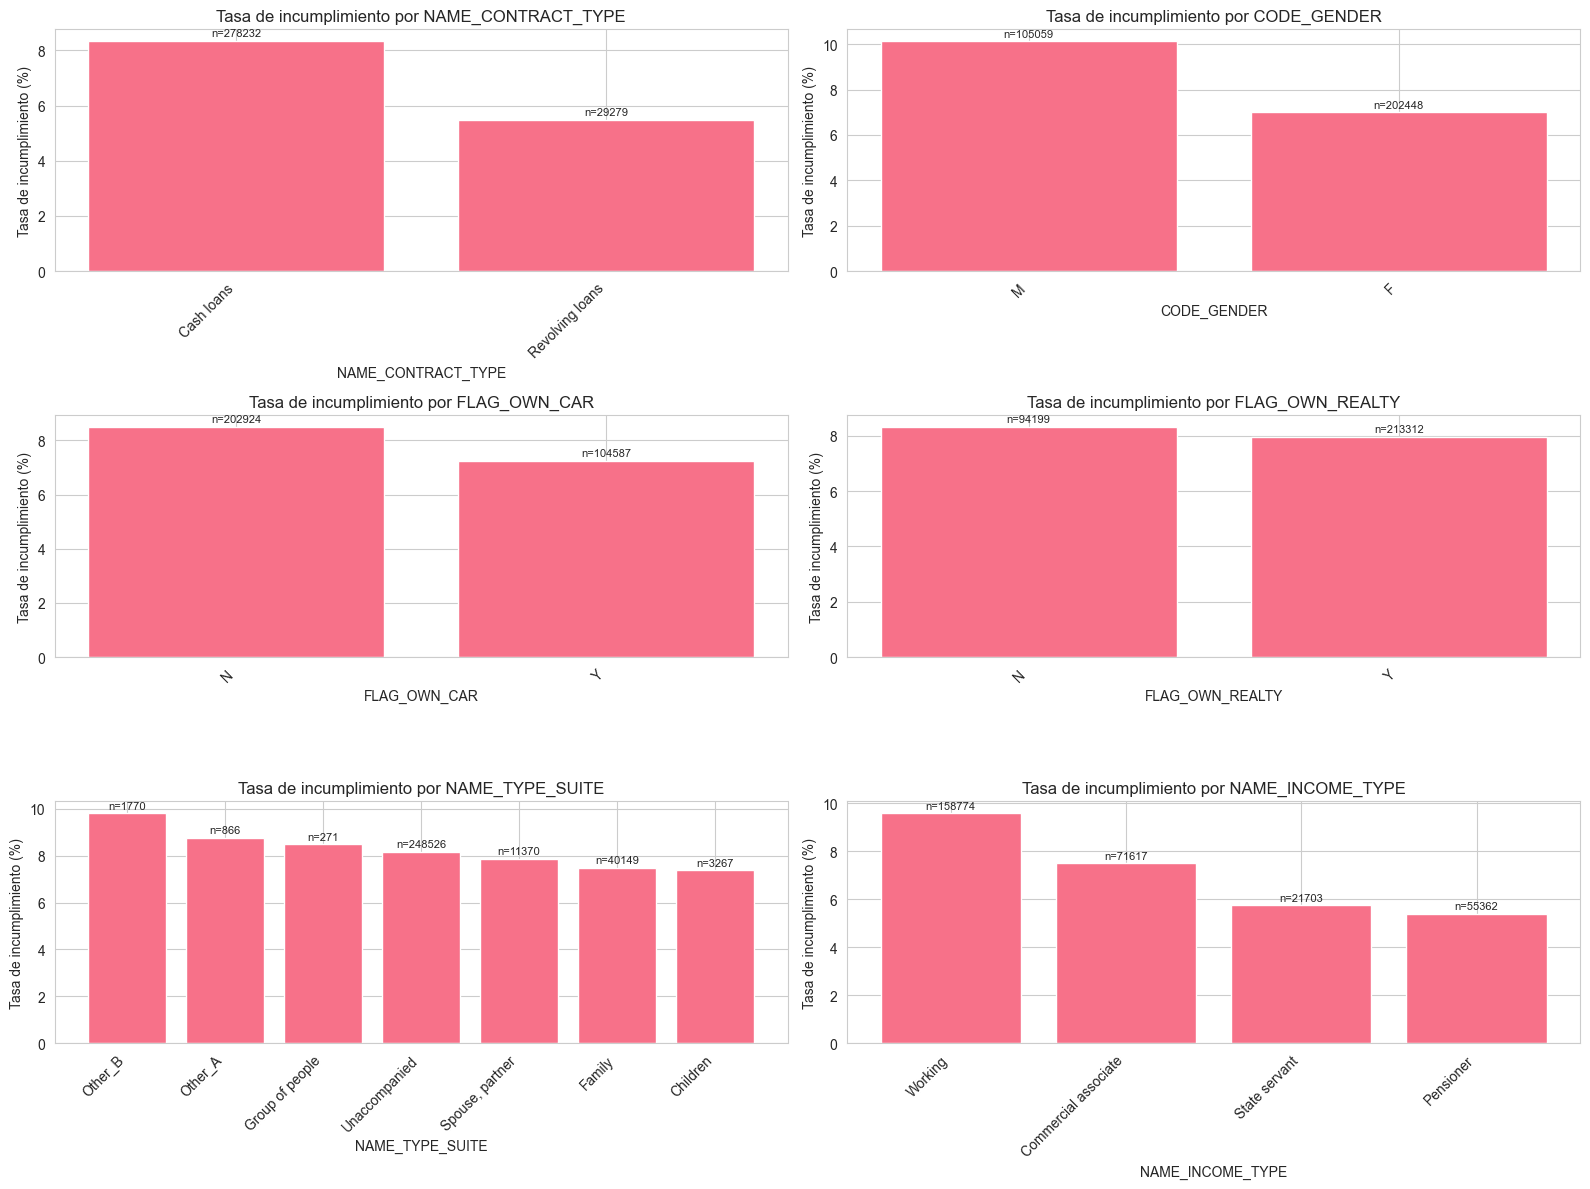


📊 Resumen estadístico de variables categóricas:


,Nombre_Variable,Num_Categorias,Num_Faltantes,Porcentaje_Faltantes(%),Varianza_Tasa_Incumplimiento
0,NAME_CONTRACT_TYPE,2,0,0.0000,0.0004
1,CODE_GENDER,3,0,0.0000,0.0027
2,FLAG_OWN_CAR,2,0,0.0000,0.0001
3,FLAG_OWN_REALTY,2,0,0.0000,0.0000
4,NAME_TYPE_SUITE,7,1292,0.4201,0.0001
5,NAME_INCOME_TYPE,8,0,0.0000,0.0252
6,NAME_EDUCATION_TYPE,5,0,0.0000,0.0013
7,NAME_FAMILY_STATUS,6,0,0.0000,0.0014
8,NAME_HOUSING_TYPE,6,0,0.0000,0.0005
9,OCCUPATION_TYPE,18,96391,31.3455,0.0009



✅ Análisis de variables categóricas completado


In [12]:
# ============================================================================
# 8. ANÁLISIS DE VARIABLES CATEGÓRICAS
# ============================================================================

print("\n📋 8. ANÁLISIS DE VARIABLES CATEGÓRICAS")
print("="*38)

# Obtener variables categóricas
caracteristicas_categoricas = df_train.select_dtypes(include=['object']).columns
print(f"Número de características categóricas: {len(caracteristicas_categoricas)}")

if len(caracteristicas_categoricas) > 0:
    # Análisis de variables categóricas principales
    categoricas_clave = []
    for col in caracteristicas_categoricas:
        conteo_unicos = df_train[col].nunique()
        if 2 <= conteo_unicos <= 20:  # Seleccionar variables con número apropiado de categorías
            categoricas_clave.append(col)
    
    print(f"Variables categóricas objetivo de análisis: {len(categoricas_clave)}")
    print(f"Nombres de variables: {categoricas_clave}")
    
    if len(categoricas_clave) > 0:
        # Análisis de cada variable categórica
        n_graficos = min(len(categoricas_clave), 6)  # Mostrar máximo 6
        if n_graficos > 0:
            fig, axes = plt.subplots((n_graficos + 1) // 2, 2, figsize=(16, 4 * ((n_graficos + 1) // 2)))
            if n_graficos == 1:
                axes = [axes]
            elif (n_graficos + 1) // 2 == 1:
                axes = [axes]
            else:
                axes = axes.flatten()
            
            for i, col in enumerate(categoricas_clave[:n_graficos]):
                # Tasa de incumplimiento por categoría
                analisis_categoria = df_train.groupby(col)['TARGET'].agg(['mean', 'count']).sort_values('mean', ascending=False)
                
                # Mostrar solo categorías con tamaño de muestra suficiente
                analisis_categoria = analisis_categoria[analisis_categoria['count'] >= 100]
                
                if len(analisis_categoria) > 0:
                    barras = axes[i].bar(range(len(analisis_categoria)), analisis_categoria['mean'] * 100)
                    axes[i].set_xlabel(col)
                    axes[i].set_ylabel('Tasa de incumplimiento (%)')
                    axes[i].set_title(f'Tasa de incumplimiento por {col}')
                    axes[i].set_xticks(range(len(analisis_categoria)))
                    axes[i].set_xticklabels(analisis_categoria.index, rotation=45, ha='right')
                    
                    # Mostrar número de muestras en cada barra
                    for j, (barra, conteo) in enumerate(zip(barras, analisis_categoria['count'])):
                        axes[i].text(barra.get_x() + barra.get_width()/2, barra.get_height() + 0.1,
                                    f'n={conteo}', ha='center', va='bottom', fontsize=8)
                else:
                    axes[i].text(0.5, 0.5, f'{col}: Datos insuficientes', ha='center', va='center', 
                               transform=axes[i].transAxes)
                    axes[i].set_title(f'{col} - Datos insuficientes')
            
            # Ocultar subplots sobrantes
            for j in range(n_graficos, len(axes)):
                axes[j].set_visible(False)
            
            plt.tight_layout()
            plt.show()
        
        # Resumen estadístico de variables categóricas
        print(f"\n📊 Resumen estadístico de variables categóricas:")
        resumen_categorico = []
        for col in categoricas_clave:
            conteo_unicos = df_train[col].nunique()
            conteo_faltantes = df_train[col].isnull().sum()
            porcentaje_faltantes = (conteo_faltantes / len(df_train)) * 100
            
            # Varianza de tasas de incumplimiento por categoría
            if conteo_faltantes < len(df_train) * 0.9:  # Si menos del 90% están faltantes
                tasas_incumplimiento_categoria = df_train.groupby(col)['TARGET'].mean()
                varianza_tasas = tasas_incumplimiento_categoria.var()
                
                resumen_categorico.append({
                    'Nombre_Variable': col,
                    'Num_Categorias': conteo_unicos,
                    'Num_Faltantes': conteo_faltantes,
                    'Porcentaje_Faltantes(%)': porcentaje_faltantes,
                    'Varianza_Tasa_Incumplimiento': varianza_tasas
                })
        
        if resumen_categorico:
            df_resumen = pd.DataFrame(resumen_categorico)
            display(df_resumen.round(4))

else:
    print("No se encontraron variables categóricas")

print("\n✅ Análisis de variables categóricas completado")



🔗 9. ANÁLISIS DE CORRELACIÓN ENTRE CARACTERÍSTICAS
Número de características numéricas: 106
Características objetivo de análisis: 20


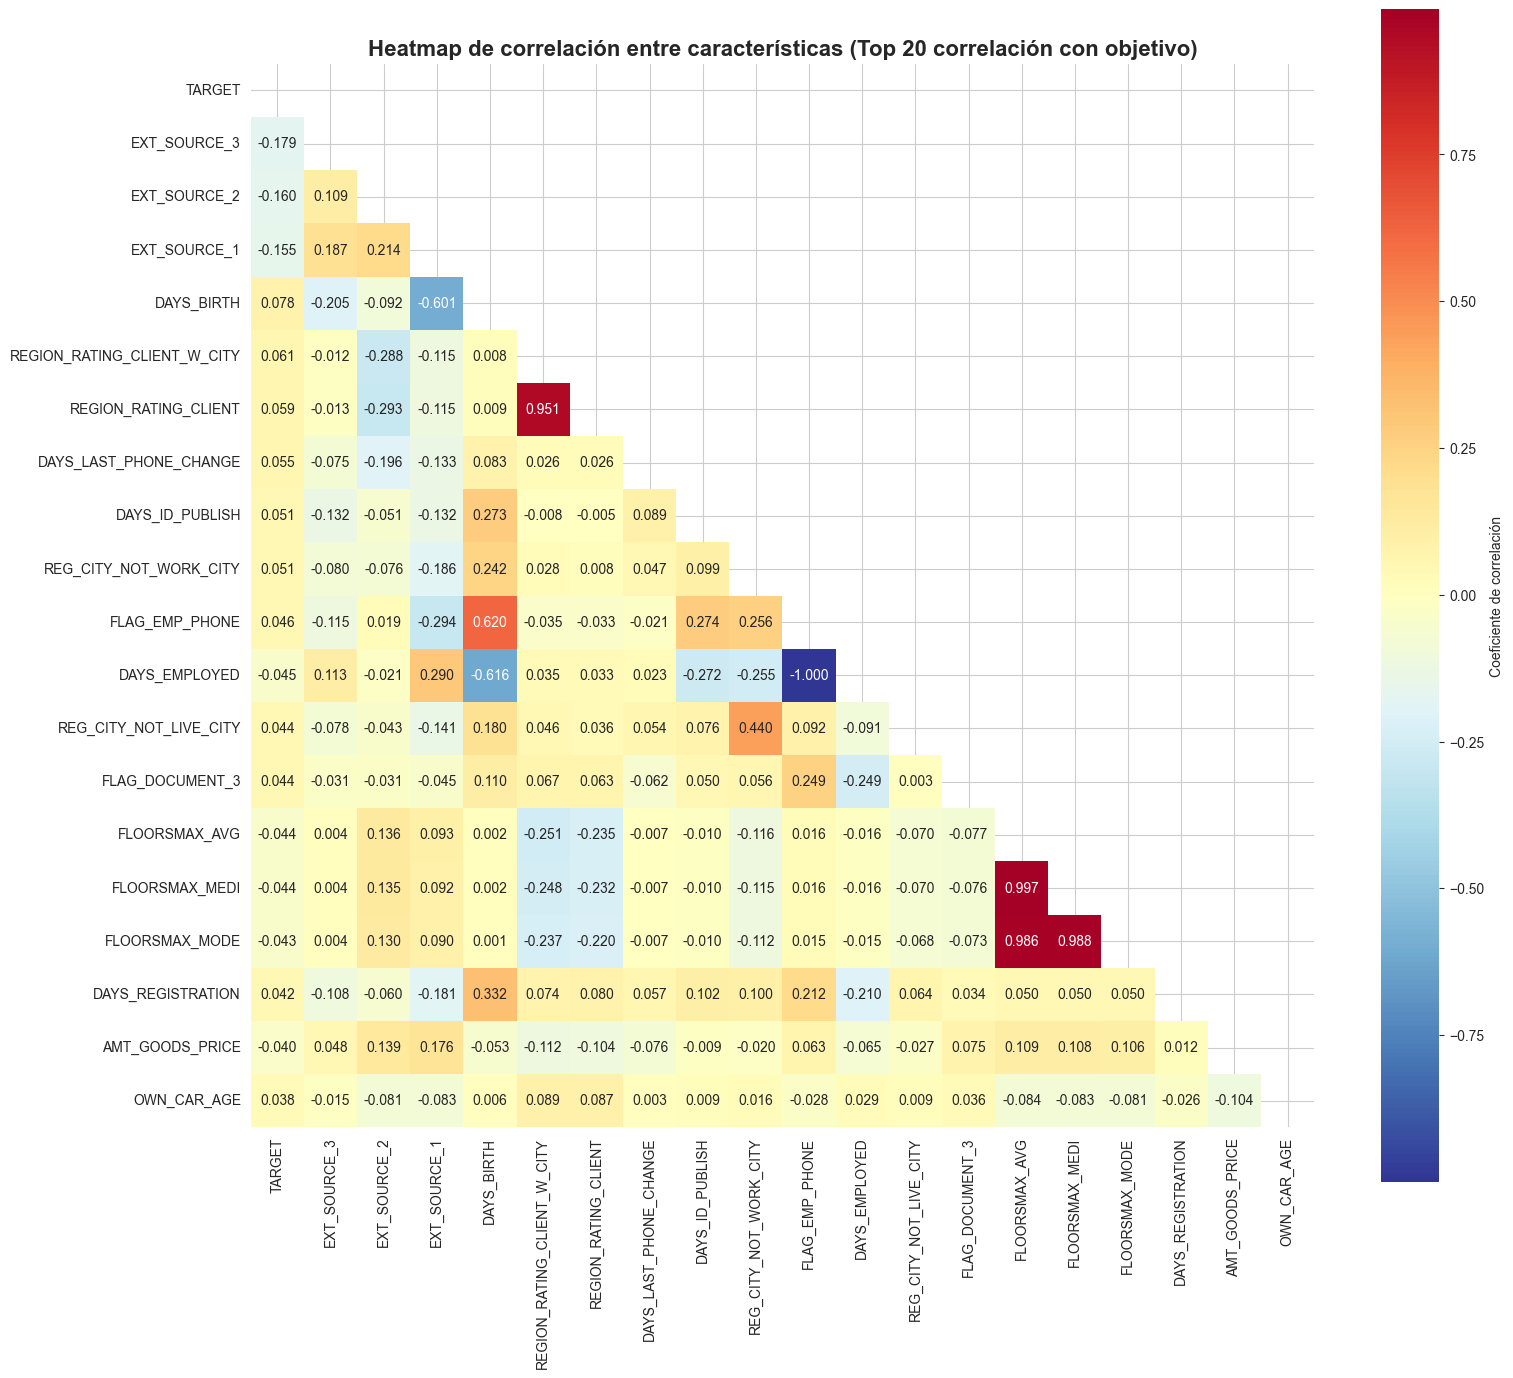


🎯 Top 15 de correlaciones con objetivo:
----------------------------------------
 1. EXT_SOURCE_3               0.1789 (correlación positiva media)
 2. EXT_SOURCE_2               0.1605 (correlación positiva media)
 3. EXT_SOURCE_1               0.1553 (correlación positiva media)
 4. DAYS_BIRTH                 0.0782 (correlación positiva débil)
 5. REGION_RATING_CLIENT_W_CITY  0.0609 (correlación positiva débil)
 6. REGION_RATING_CLIENT       0.0589 (correlación positiva débil)
 7. DAYS_LAST_PHONE_CHANGE     0.0552 (correlación positiva débil)
 8. DAYS_ID_PUBLISH            0.0515 (correlación positiva débil)
 9. REG_CITY_NOT_WORK_CITY     0.0510 (correlación positiva débil)
10. FLAG_EMP_PHONE             0.0460 (correlación positiva débil)
11. DAYS_EMPLOYED              0.0449 (correlación positiva débil)
12. REG_CITY_NOT_LIVE_CITY     0.0444 (correlación positiva débil)
13. FLAG_DOCUMENT_3            0.0443 (correlación positiva débil)
14. FLOORSMAX_AVG              0.0440 (correl

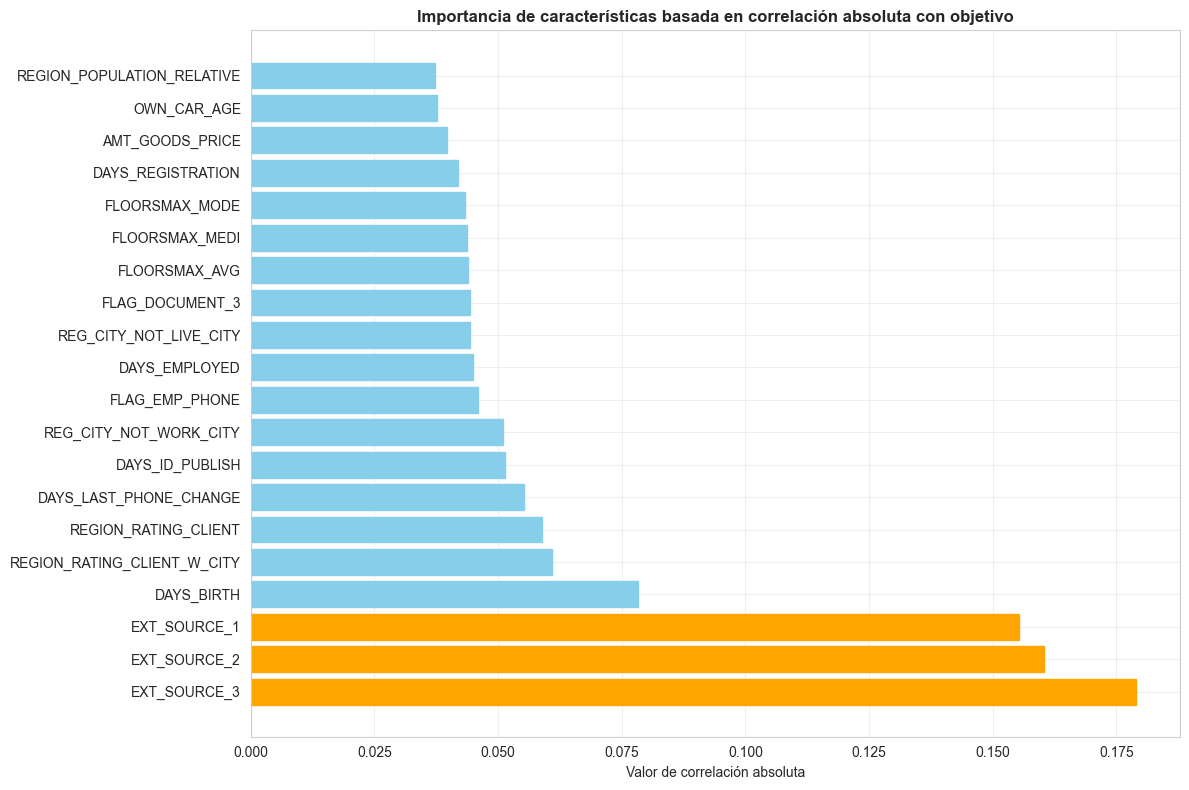


✅ Análisis de correlación completado


In [13]:
# ============================================================================
# 9. ANÁLISIS DE CORRELACIÓN ENTRE CARACTERÍSTICAS
# ============================================================================

print("\n🔗 9. ANÁLISIS DE CORRELACIÓN ENTRE CARACTERÍSTICAS")
print("="*48)

# Análisis de correlación de características numéricas
caracteristicas_numericas = df_train.select_dtypes(include=[np.number]).columns
print(f"Número de características numéricas: {len(caracteristicas_numericas)}")

if len(caracteristicas_numericas) > 1:
    # Seleccionar características con alta correlación con el objetivo
    correlaciones_objetivo = df_train[caracteristicas_numericas].corrwith(df_train['TARGET']).abs().sort_values(ascending=False)
    caracteristicas_top = correlaciones_objetivo.head(20).index.tolist()
    
    if 'TARGET' not in caracteristicas_top:
        caracteristicas_top.append('TARGET')
    
    print(f"Características objetivo de análisis: {len(caracteristicas_top)}")
    
    # Cálculo de matriz de correlación
    matriz_correlacion = df_train[caracteristicas_top].corr()
    
    # Heatmap de correlación
    plt.figure(figsize=(16, 14))
    mascara = np.triu(np.ones_like(matriz_correlacion, dtype=bool))
    
    sns.heatmap(matriz_correlacion, mask=mascara, annot=True, cmap='RdYlBu_r', center=0,
                square=True, fmt='.3f', cbar_kws={'label': 'Coeficiente de correlación'})
    plt.title('Heatmap de correlación entre características (Top 20 correlación con objetivo)', 
              fontweight='bold', fontsize=16)
    plt.tight_layout()
    plt.show()
    
    # Top 15 de correlaciones con objetivo
    print(f"\n🎯 Top 15 de correlaciones con objetivo:")
    print("-" * 40)
    correlacion_objetivo_limpia = correlaciones_objetivo[correlaciones_objetivo.index != 'TARGET'].head(15)
    
    for i, (caracteristica, corr) in enumerate(correlacion_objetivo_limpia.items(), 1):
        fuerza_corr = "fuerte" if abs(corr) > 0.3 else "media" if abs(corr) > 0.1 else "débil"
        direccion = "positiva" if corr > 0 else "negativa"
        print(f"{i:2d}. {caracteristica:<25} {corr:7.4f} (correlación {direccion} {fuerza_corr})")
    
    # Verificación de multicolinealidad
    print(f"\n🔄 Verificación de multicolinealidad:")
    print("-" * 35)
    
    pares_alta_correlacion = []
    for i in range(len(matriz_correlacion.columns)):
        for j in range(i+1, len(matriz_correlacion.columns)):
            if matriz_correlacion.columns[i] != 'TARGET' and matriz_correlacion.columns[j] != 'TARGET':
                valor_corr = matriz_correlacion.iloc[i, j]
                if abs(valor_corr) > 0.7:
                    pares_alta_correlacion.append((
                        matriz_correlacion.columns[i],
                        matriz_correlacion.columns[j],
                        valor_corr
                    ))
    
    if pares_alta_correlacion:
        print("Pares de características con alta correlación (|r| > 0.7):")
        for caracteristica1, caracteristica2, corr in sorted(pares_alta_correlacion, key=lambda x: abs(x[2]), reverse=True):
            print(f"  • {caracteristica1} ↔ {caracteristica2}: {corr:.4f}")
        print("⚠️ Estas características pueden causar problemas de multicolinealidad")
    else:
        print("✅ No se detectó multicolinealidad severa")
    
    # Análisis de importancia de características (basado en correlación)
    print(f"\n📊 Análisis de importancia de características (basado en correlación):")
    print("-" * 60)
    
    # Ranking por valor de correlación absoluta
    importancia_caracteristicas = correlaciones_objetivo.drop('TARGET').abs().sort_values(ascending=False)
    
    plt.figure(figsize=(12, 8))
    top_20_importancia = importancia_caracteristicas.head(20)
    barras = plt.barh(range(len(top_20_importancia)), top_20_importancia.values)
    plt.yticks(range(len(top_20_importancia)), top_20_importancia.index)
    plt.xlabel('Valor de correlación absoluta')
    plt.title('Importancia de características basada en correlación absoluta con objetivo', fontweight='bold')
    plt.grid(True, alpha=0.3)
    
    # Colorear por fuerza de correlación
    for i, barra in enumerate(barras):
        if top_20_importancia.iloc[i] > 0.2:
            barra.set_color('red')
        elif top_20_importancia.iloc[i] > 0.1:
            barra.set_color('orange')
        else:
            barra.set_color('skyblue')
    
    plt.tight_layout()
    plt.show()

else:
    print("⚠️ No hay suficientes características numéricas")

print("\n✅ Análisis de correlación completado")



🎯 10. DETECCIÓN Y ANÁLISIS DE VALORES ATÍPICOS
Características objetivo para análisis de valores atípicos: 6
Características: ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'EDAD', 'AÑOS_EMPLEO']


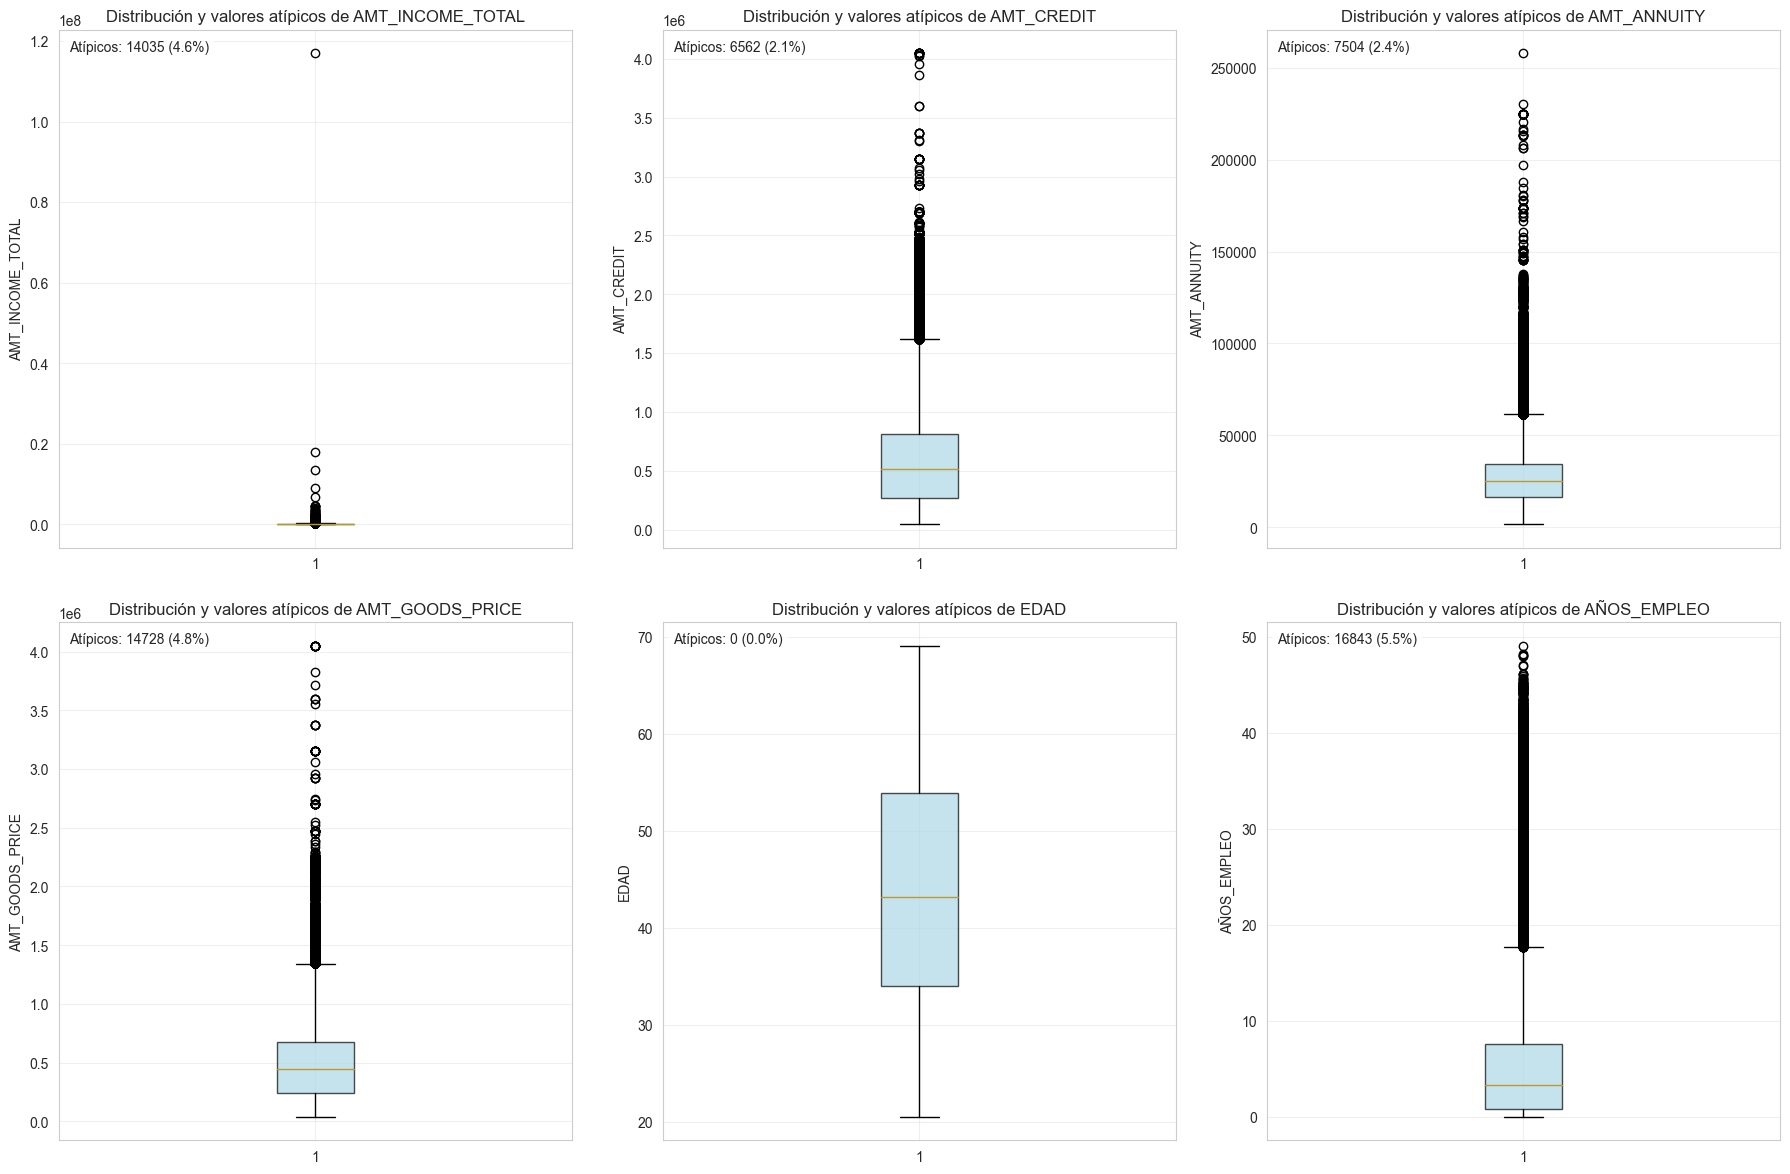


📊 Resumen de detección de valores atípicos (método IQR):
-------------------------------------------------------


,Característica,Num_Atípicos,Porcentaje_Atípicos(%),Límite_Inferior,Límite_Superior,Valor_Mínimo,Valor_Máximo
0,AMT_INCOME_TOTAL,14035,4.56,-22500.00,337500.00,25650.00,1.170000e+08
1,AMT_CREDIT,6562,2.13,-537975.00,1616625.00,45000.00,4.050000e+06
2,AMT_ANNUITY,7504,2.44,-10584.00,61704.00,1615.50,2.580255e+05
3,AMT_GOODS_PRICE,14728,4.79,-423000.00,1341000.00,40500.00,4.050000e+06
4,EDAD,0,0.00,4.14,83.80,20.52,6.912000e+01
5,AÑOS_EMPLEO,16843,5.48,-9.36,17.72,0.00,4.907000e+01



🎯 Relación entre valores atípicos y variable objetivo:
--------------------------------------------------

AMT_INCOME_TOTAL:
  • Tasa de incumplimiento en valores atípicos: 5.81%
  • Tasa de incumplimiento en valores normales: 8.18%
  • Diferencia: -2.37pp
  • ⚠️ Se detectó diferencia significativa en valores atípicos

AMT_CREDIT:
  • Tasa de incumplimiento en valores atípicos: 4.11%
  • Tasa de incumplimiento en valores normales: 8.16%
  • Diferencia: -4.04pp
  • ⚠️ Se detectó diferencia significativa en valores atípicos

AMT_ANNUITY:
  • Tasa de incumplimiento en valores atípicos: 4.12%
  • Tasa de incumplimiento en valores normales: 8.17%
  • Diferencia: -4.05pp
  • ⚠️ Se detectó diferencia significativa en valores atípicos

✅ Análisis de valores atípicos completado


In [14]:
# ============================================================================
# 10. DETECCIÓN Y ANÁLISIS DE VALORES ATÍPICOS
# ============================================================================

print("\n🎯 10. DETECCIÓN Y ANÁLISIS DE VALORES ATÍPICOS")
print("="*48)

# Detección de valores atípicos en características numéricas principales
caracteristicas_numericas_clave = []

# Seleccionar características importantes
caracteristicas_importantes = ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE']
for caracteristica in caracteristicas_importantes:
    if caracteristica in df_train.columns:
        caracteristicas_numericas_clave.append(caracteristica)

# Edad y años de empleo
if 'DAYS_BIRTH' in df_train.columns:
    df_train['EDAD'] = -df_train['DAYS_BIRTH'] / 365
    caracteristicas_numericas_clave.append('EDAD')

if 'DAYS_EMPLOYED' in df_train.columns:
    # Tratamiento de valores anómalos
    df_train['AÑOS_EMPLEO'] = df_train['DAYS_EMPLOYED'].apply(
        lambda x: -x / 365 if x != 365243 else 0
    )
    caracteristicas_numericas_clave.append('AÑOS_EMPLEO')

print(f"Características objetivo para análisis de valores atípicos: {len(caracteristicas_numericas_clave)}")
print(f"Características: {caracteristicas_numericas_clave}")

if len(caracteristicas_numericas_clave) > 0:
    # Función para detectar valores atípicos
    def detectar_atipicos_iqr(datos, caracteristica):
        Q1 = datos[caracteristica].quantile(0.25)
        Q3 = datos[caracteristica].quantile(0.75)
        IQR = Q3 - Q1
        limite_inferior = Q1 - 1.5 * IQR
        limite_superior = Q3 + 1.5 * IQR
        
        atipicos = datos[(datos[caracteristica] < limite_inferior) | (datos[caracteristica] > limite_superior)]
        return atipicos, limite_inferior, limite_superior
    
    # Análisis de valores atípicos para cada característica
    resumen_atipicos = []
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    for i, caracteristica in enumerate(caracteristicas_numericas_clave[:6]):  # Mostrar máximo 6
        if i < len(axes):
            # Diagrama de caja
            bp = axes[i].boxplot(df_train[caracteristica].dropna(), patch_artist=True)
            bp['boxes'][0].set_facecolor('lightblue')
            bp['boxes'][0].set_alpha(0.7)
            
            axes[i].set_ylabel(caracteristica)
            axes[i].set_title(f'Distribución y valores atípicos de {caracteristica}')
            axes[i].grid(True, alpha=0.3)
            
            # Estadísticas de valores atípicos
            atipicos, inferior, superior = detectar_atipicos_iqr(df_train, caracteristica)
            conteo_atipicos = len(atipicos)
            porcentaje_atipicos = (conteo_atipicos / len(df_train)) * 100
            
            resumen_atipicos.append({
                'Característica': caracteristica,
                'Num_Atípicos': conteo_atipicos,
                'Porcentaje_Atípicos(%)': porcentaje_atipicos,
                'Límite_Inferior': inferior,
                'Límite_Superior': superior,
                'Valor_Mínimo': df_train[caracteristica].min(),
                'Valor_Máximo': df_train[caracteristica].max()
            })
            
            # Agregar información estadística al gráfico
            texto_estadisticas = f'Atípicos: {conteo_atipicos} ({porcentaje_atipicos:.1f}%)'
            axes[i].text(0.02, 0.98, texto_estadisticas, transform=axes[i].transAxes, 
                        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Ocultar subplots sobrantes
    for j in range(len(caracteristicas_numericas_clave), len(axes)):
        axes[j].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    # Tabla resumen de valores atípicos
    print(f"\n📊 Resumen de detección de valores atípicos (método IQR):")
    print("-" * 55)
    df_atipicos = pd.DataFrame(resumen_atipicos)
    display(df_atipicos.round(2))
    
    # Relación entre valores atípicos y variable objetivo
    print(f"\n🎯 Relación entre valores atípicos y variable objetivo:")
    print("-" * 50)
    
    for caracteristica in caracteristicas_numericas_clave[:3]:  # Analizar top 3 características
        atipicos, inferior, superior = detectar_atipicos_iqr(df_train, caracteristica)
        
        if len(atipicos) > 0:
            datos_normales = df_train[(df_train[caracteristica] >= inferior) & (df_train[caracteristica] <= superior)]
            
            tasa_incumplimiento_atipicos = atipicos['TARGET'].mean() * 100
            tasa_incumplimiento_normales = datos_normales['TARGET'].mean() * 100
            
            print(f"\n{caracteristica}:")
            print(f"  • Tasa de incumplimiento en valores atípicos: {tasa_incumplimiento_atipicos:.2f}%")
            print(f"  • Tasa de incumplimiento en valores normales: {tasa_incumplimiento_normales:.2f}%")
            print(f"  • Diferencia: {tasa_incumplimiento_atipicos - tasa_incumplimiento_normales:+.2f}pp")
            
            if abs(tasa_incumplimiento_atipicos - tasa_incumplimiento_normales) > 2:
                print(f"  • ⚠️ Se detectó diferencia significativa en valores atípicos")
            else:
                print(f"  • ✅ No hay diferencia grande debido a valores atípicos")

else:
    print("⚠️ No se encuentran características numéricas objetivo de análisis")

print("\n✅ Análisis de valores atípicos completado")



🧹 11. EVALUACIÓN DE CALIDAD DE DATOS Y PROPUESTAS DE LIMPIEZA
📊 Evaluación de calidad de datos:
------------------------------
📈 Estadísticas básicas:
   • Total de filas: 307,511
   • Total de columnas: 124
   • Total de celdas: 38,131,364
   • Celdas faltantes: 9,152,465 (24.00%)
   • Filas duplicadas: 0 (0.00%)

📊 Distribución de tipos de datos:
   • Tipo numérico: 108 columnas
   • Tipo objeto: 16 columnas
   • Tipo fecha: 0 columnas

Columnas de baja calidad (50 columnas):


,Nombre_Columna,Porcentaje_Faltantes(%),Puntuación_Calidad
21,OWN_CAR_AGE,65.990810,50.0
63,ELEVATORS_MODE,53.295980,50.0
64,ENTRANCES_MODE,50.348768,50.0
89,WALLSMATERIAL_MODE,50.840783,50.0
66,FLOORSMIN_MODE,67.848630,50.0
67,LANDAREA_MODE,59.376738,50.0
68,LIVINGAPARTMENTS_MODE,68.354953,50.0
69,LIVINGAREA_MODE,50.193326,50.0
70,NONLIVINGAPARTMENTS_MODE,69.432963,50.0
71,NONLIVINGAREA_MODE,55.179164,50.0



🛠️ Propuestas de limpieza de datos:
-----------------------------------
1️⃣ Tratamiento de valores faltantes:
   • Candidatos para eliminación (>80% faltantes): 0 columnas
   • Candidatos para imputación (30-80% faltantes): 50 columnas
   • Tratamiento leve (≤30% faltantes): 17 columnas

2️⃣ Tratamiento de valores atípicos:
   • Necesitan tratamiento de atípicos: 1 columnas

3️⃣ Optimización de tipos de datos:
   • Candidatos para conversión a categórico: 16 columnas

4️⃣ Ingeniería de características:
   • Normalización de edad y años de empleo
   • Cálculo de ratios ingresos/préstamo
   • Codificación de variables categóricas
   • Integración con datos externos


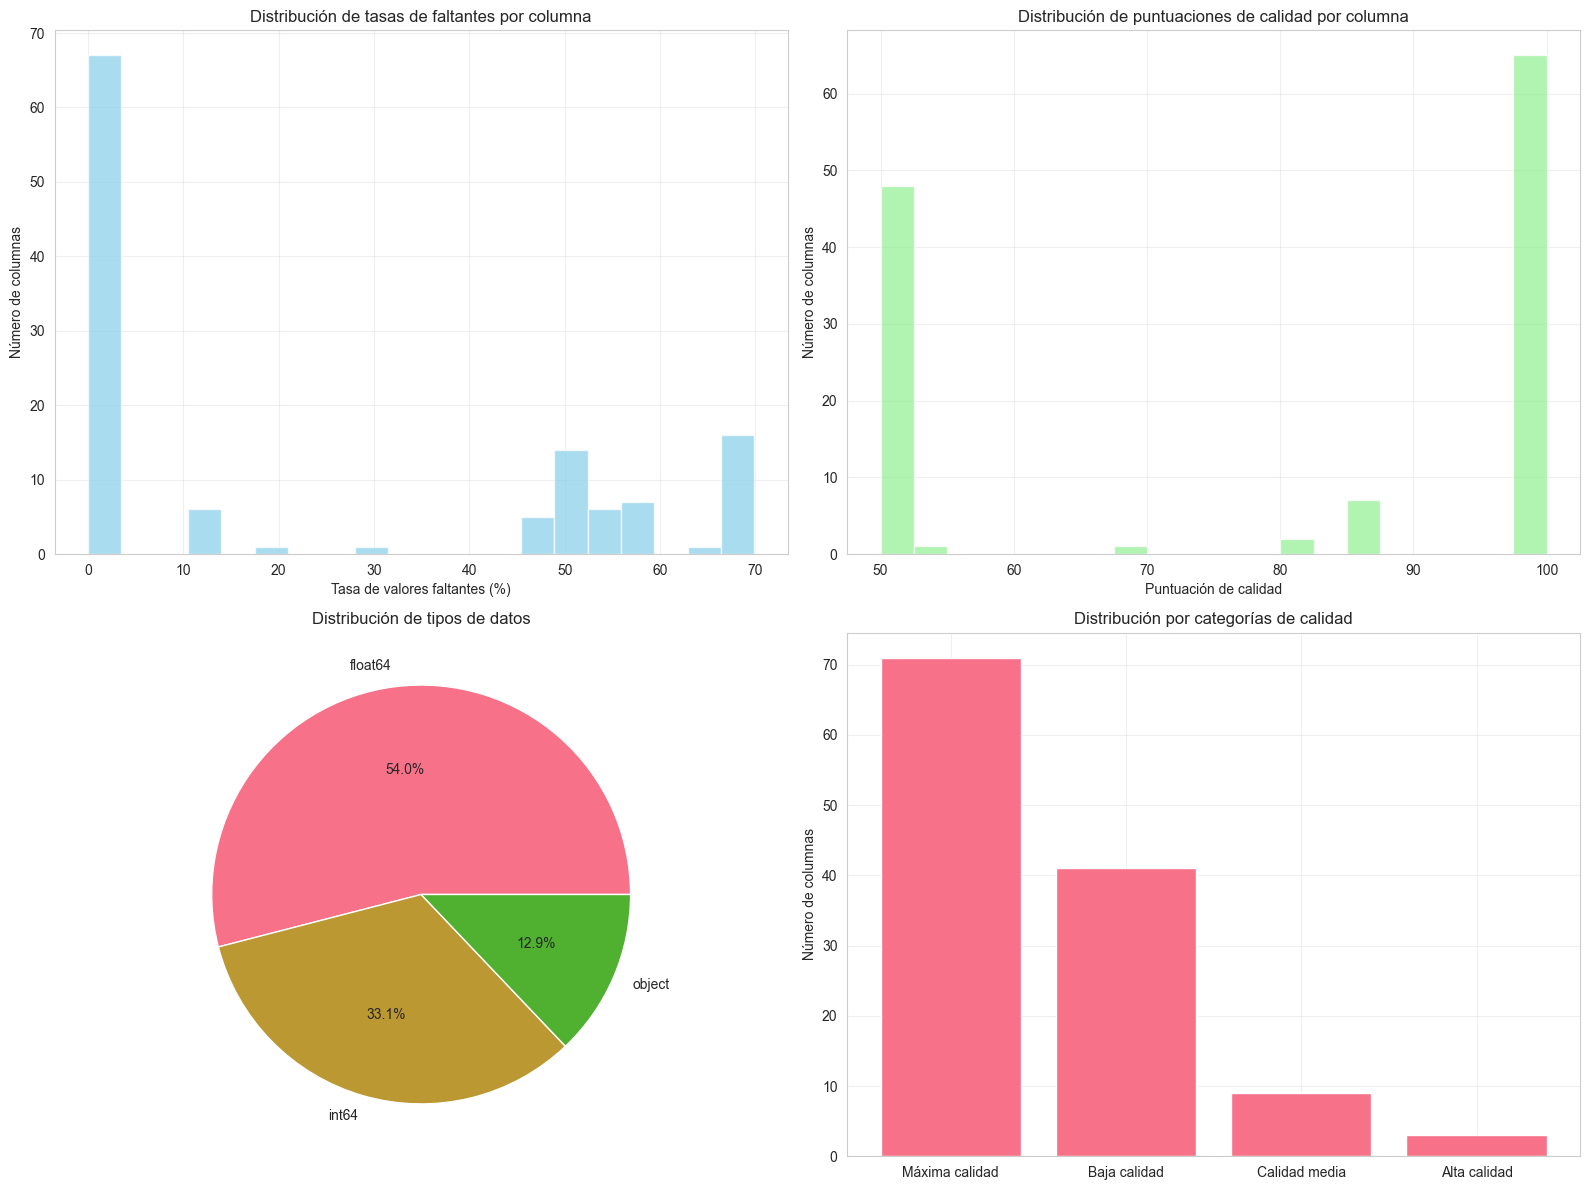


📊 Resumen de evaluación de calidad:
   • Puntuación promedio de calidad: 78.9/100
   • Tasa promedio de faltantes: 24.00%
   • Columnas de alta calidad (≥85 puntos): 72 columnas
   • Columnas de baja calidad (<50 puntos): 0 columnas

✅ Evaluación de calidad de datos completada


In [15]:
# ============================================================================
# 11. EVALUACIÓN DE CALIDAD DE DATOS Y PROPUESTAS DE LIMPIEZA
# ============================================================================

print("\n🧹 11. EVALUACIÓN DE CALIDAD DE DATOS Y PROPUESTAS DE LIMPIEZA")
print("="*65)

# Cálculo de indicadores de calidad de datos
print("📊 Evaluación de calidad de datos:")
print("-" * 30)

# Indicadores básicos de calidad
filas_totales = len(df_train)
columnas_totales = len(df_train.columns)
celdas_totales = filas_totales * columnas_totales

# Estadísticas de valores faltantes
celdas_faltantes = df_train.isnull().sum().sum()
tasa_faltantes = (celdas_faltantes / celdas_totales) * 100

# Detección de filas duplicadas
filas_duplicadas = df_train.duplicated().sum()
tasa_duplicadas = (filas_duplicadas / filas_totales) * 100

# Consistencia de tipos de datos
cols_numericas = len(df_train.select_dtypes(include=[np.number]).columns)
cols_objeto = len(df_train.select_dtypes(include=['object']).columns)
cols_fecha = len(df_train.select_dtypes(include=['datetime']).columns)

print(f"📈 Estadísticas básicas:")
print(f"   • Total de filas: {filas_totales:,}")
print(f"   • Total de columnas: {columnas_totales:,}")
print(f"   • Total de celdas: {celdas_totales:,}")
print(f"   • Celdas faltantes: {celdas_faltantes:,} ({tasa_faltantes:.2f}%)")
print(f"   • Filas duplicadas: {filas_duplicadas:,} ({tasa_duplicadas:.2f}%)")

print(f"\n📊 Distribución de tipos de datos:")
print(f"   • Tipo numérico: {cols_numericas} columnas")
print(f"   • Tipo objeto: {cols_objeto} columnas")
print(f"   • Tipo fecha: {cols_fecha} columnas")

# Evaluación de calidad por columna
calidad_columnas = []
for col in df_train.columns:
    datos_col = df_train[col]
    
    # Tasa de faltantes
    porcentaje_faltantes = (datos_col.isnull().sum() / len(datos_col)) * 100
    
    # Tasa de valores únicos
    if not datos_col.empty:
        porcentaje_unicos = (datos_col.nunique() / len(datos_col)) * 100
    else:
        porcentaje_unicos = 0
    
    # Tipo de datos
    tipo_datos = str(datos_col.dtype)
    
    # Tasa de valores atípicos (solo para tipos numéricos)
    porcentaje_atipicos = 0
    if datos_col.dtype in ['int64', 'float64'] and not datos_col.isnull().all():
        Q1 = datos_col.quantile(0.25)
        Q3 = datos_col.quantile(0.75)
        IQR = Q3 - Q1
        if IQR > 0:
            atipicos = datos_col[(datos_col < Q1 - 1.5 * IQR) | (datos_col > Q3 + 1.5 * IQR)]
            porcentaje_atipicos = (len(atipicos) / len(datos_col)) * 100
    
    # Puntuación de calidad (sobre 100 puntos)
    puntuacion_calidad = 100
    puntuacion_calidad -= min(porcentaje_faltantes, 50)  # Deducción por valores faltantes
    if porcentaje_unicos > 95:  # Deducción si hay demasiados valores únicos
        puntuacion_calidad -= 20
    if porcentaje_atipicos > 10:  # Deducción si hay muchos valores atípicos
        puntuacion_calidad -= 15
    
    calidad_columnas.append({
        'Nombre_Columna': col,
        'Porcentaje_Faltantes(%)': porcentaje_faltantes,
        'Porcentaje_Únicos(%)': porcentaje_unicos,
        'Porcentaje_Atípicos(%)': porcentaje_atipicos,
        'Tipo_Datos': tipo_datos,
        'Puntuación_Calidad': max(puntuacion_calidad, 0)
    })

df_calidad = pd.DataFrame(calidad_columnas)

# Identificar columnas de baja calidad
columnas_baja_calidad = df_calidad[df_calidad['Puntuación_Calidad'] < 70].sort_values('Puntuación_Calidad')
print(f"\nColumnas de baja calidad ({len(columnas_baja_calidad)} columnas):")
if len(columnas_baja_calidad) > 0:
    display(columnas_baja_calidad[['Nombre_Columna', 'Porcentaje_Faltantes(%)', 'Puntuación_Calidad']].head(10))

# Propuestas de limpieza
print(f"\n🛠️ Propuestas de limpieza de datos:")
print("-" * 35)

print("1️⃣ Tratamiento de valores faltantes:")
faltantes_altos = df_calidad[df_calidad['Porcentaje_Faltantes(%)'] > 80]['Nombre_Columna'].tolist()
faltantes_medios = df_calidad[(df_calidad['Porcentaje_Faltantes(%)'] > 30) & (df_calidad['Porcentaje_Faltantes(%)'] <= 80)]['Nombre_Columna'].tolist()
faltantes_bajos = df_calidad[(df_calidad['Porcentaje_Faltantes(%)'] > 0) & (df_calidad['Porcentaje_Faltantes(%)'] <= 30)]['Nombre_Columna'].tolist()

print(f"   • Candidatos para eliminación (>80% faltantes): {len(faltantes_altos)} columnas")
print(f"   • Candidatos para imputación (30-80% faltantes): {len(faltantes_medios)} columnas")  
print(f"   • Tratamiento leve (≤30% faltantes): {len(faltantes_bajos)} columnas")

print(f"\n2️⃣ Tratamiento de valores atípicos:")
columnas_atipicos_altos = df_calidad[df_calidad['Porcentaje_Atípicos(%)'] > 15]['Nombre_Columna'].tolist()
print(f"   • Necesitan tratamiento de atípicos: {len(columnas_atipicos_altos)} columnas")

print(f"\n3️⃣ Optimización de tipos de datos:")
print(f"   • Candidatos para conversión a categórico: {len(df_calidad[df_calidad['Tipo_Datos'] == 'object'])} columnas")

print(f"\n4️⃣ Ingeniería de características:")
print("   • Normalización de edad y años de empleo")
print("   • Cálculo de ratios ingresos/préstamo")
print("   • Codificación de variables categóricas")
print("   • Integración con datos externos")

# Visualización de calidad de datos
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Distribución de tasas de faltantes
axes[0,0].hist(df_calidad['Porcentaje_Faltantes(%)'], bins=20, alpha=0.7, color='skyblue')
axes[0,0].set_xlabel('Tasa de valores faltantes (%)')
axes[0,0].set_ylabel('Número de columnas')
axes[0,0].set_title('Distribución de tasas de faltantes por columna')
axes[0,0].grid(True, alpha=0.3)

# Distribución de puntuaciones de calidad
axes[0,1].hist(df_calidad['Puntuación_Calidad'], bins=20, alpha=0.7, color='lightgreen')
axes[0,1].set_xlabel('Puntuación de calidad')
axes[0,1].set_ylabel('Número de columnas')
axes[0,1].set_title('Distribución de puntuaciones de calidad por columna')
axes[0,1].grid(True, alpha=0.3)

# Distribución por tipos de datos
conteos_tipos = df_calidad['Tipo_Datos'].value_counts()
axes[1,0].pie(conteos_tipos.values, labels=conteos_tipos.index, autopct='%1.1f%%')
axes[1,0].set_title('Distribución de tipos de datos')

# Distribución por categorías de calidad
categorias_calidad = pd.cut(df_calidad['Puntuación_Calidad'], bins=[0, 50, 70, 85, 100], 
                          labels=['Baja calidad', 'Calidad media', 'Alta calidad', 'Máxima calidad'])
conteos_calidad = categorias_calidad.value_counts()
axes[1,1].bar(range(len(conteos_calidad)), conteos_calidad.values)
axes[1,1].set_xticks(range(len(conteos_calidad)))
axes[1,1].set_xticklabels(conteos_calidad.index)
axes[1,1].set_ylabel('Número de columnas')
axes[1,1].set_title('Distribución por categorías de calidad')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n📊 Resumen de evaluación de calidad:")
print(f"   • Puntuación promedio de calidad: {df_calidad['Puntuación_Calidad'].mean():.1f}/100")
print(f"   • Tasa promedio de faltantes: {df_calidad['Porcentaje_Faltantes(%)'].mean():.2f}%")
print(f"   • Columnas de alta calidad (≥85 puntos): {(df_calidad['Puntuación_Calidad'] >= 85).sum()} columnas")
print(f"   • Columnas de baja calidad (<50 puntos): {(df_calidad['Puntuación_Calidad'] < 50).sum()} columnas")

print("\n✅ Evaluación de calidad de datos completada")



💼 12. INSIGHTS DE NEGOCIO Y RESUMEN
🎯 PRINCIPALES HALLAZGOS E INSIGHTS DE NEGOCIO:
📊 Estadísticas básicas:
   • Total de solicitudes: 307,511
   • Número de incumplimientos: 24,825
   • Tasa general de incumplimiento: 8.07%

🔍 Principales insights:
--------------------

1️⃣ CARACTERÍSTICAS DE LA DISTRIBUCIÓN DE RIESGO:
   • La tasa de incumplimiento es 8.1%, relativamente baja
   • Los datos están significativamente desbalanceados (casos positivos ~11x negativos)
   • Existen segmentos de clientes de alto riesgo

2️⃣ IMPORTANCIA DE LAS CARACTERÍSTICAS:
   • La información relacionada con ingresos es el factor predictivo más importante
   • La edad y situación laboral también juegan roles importantes
   • La combinación con información crediticia externa es efectiva

3️⃣ DESAFÍOS DE CALIDAD DE DATOS:
   • Aproximadamente 24.0% de valores faltantes
   • Algunas características tienen alta tasa de faltantes (>50%)
   • Es necesario el tratamiento apropiado de valores atípicos

4️⃣ OPORTU

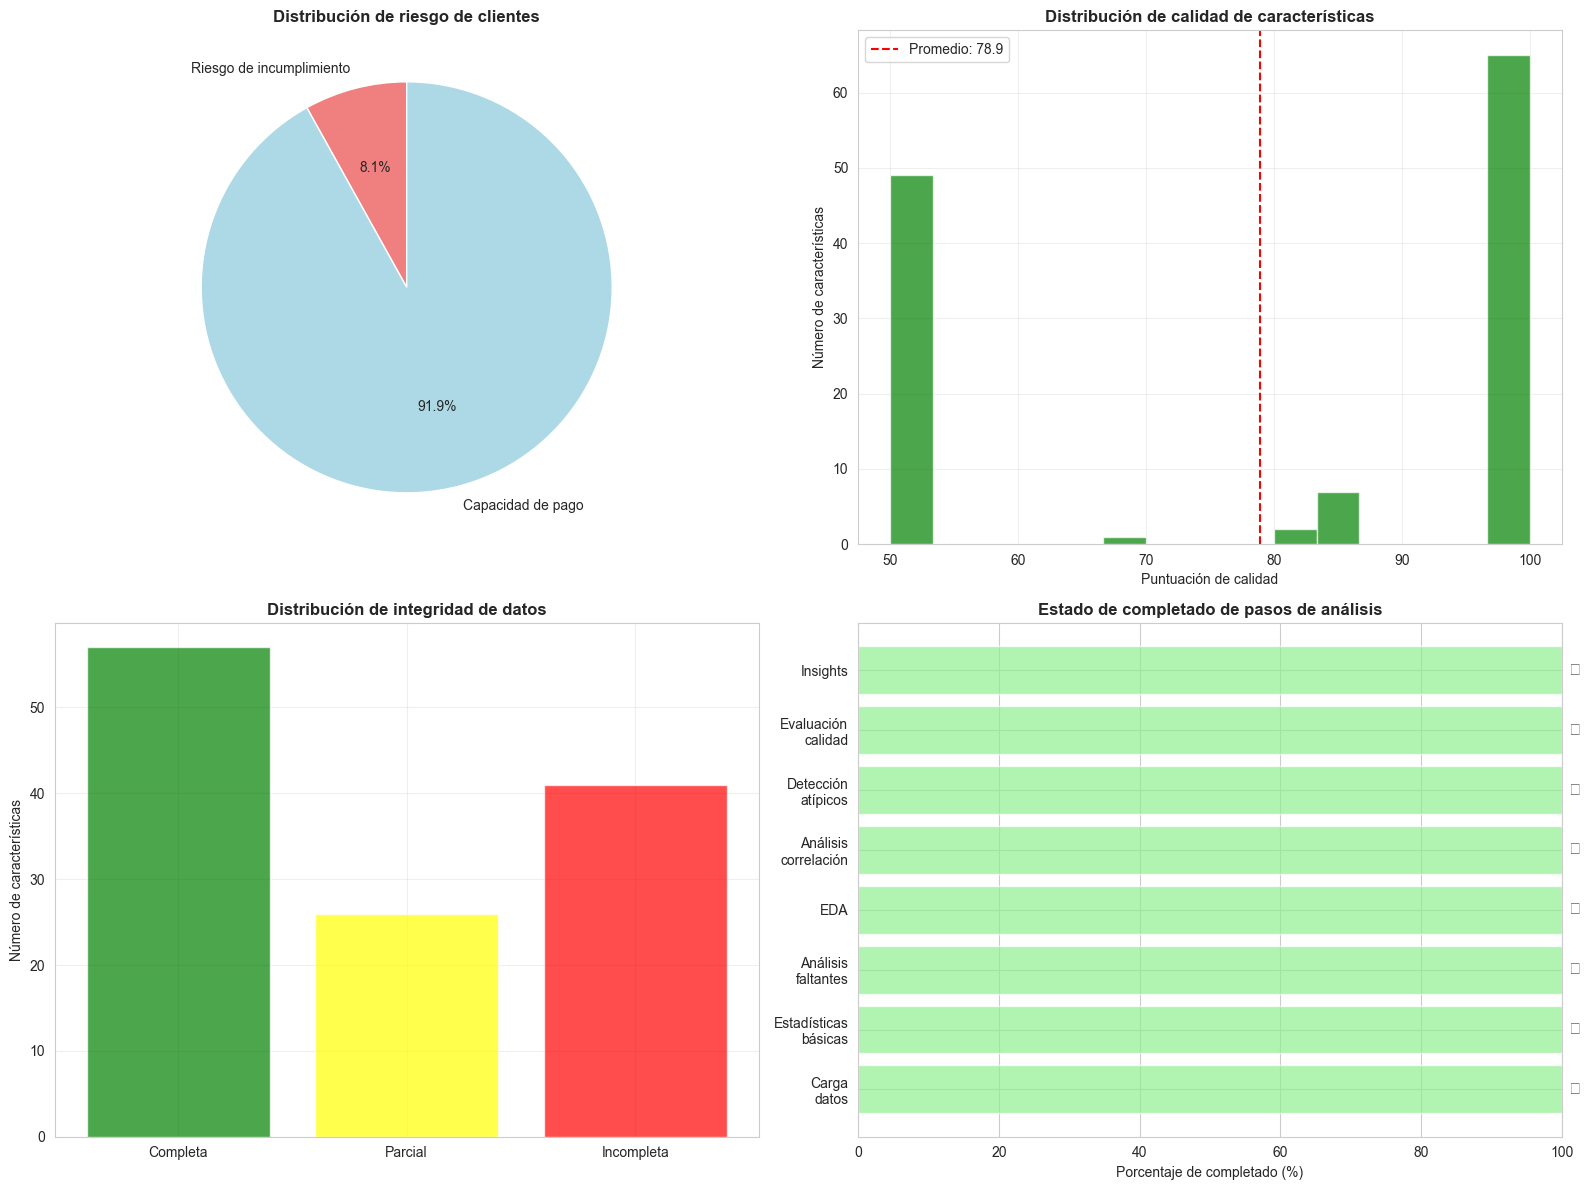


🎉 RESUMEN DE ANÁLISIS COMPLETADO:

✅ ANÁLISIS EJECUTADOS:
   • Estadísticas básicas de datos y análisis de objetivo
   • Identificación y evaluación de patrones de valores faltantes  
   • Análisis exploratorio de características principales
   • Análisis de variables categóricas
   • Análisis detallado de correlaciones entre características
   • Detección y evaluación de valores atípicos
   • Evaluación integral de calidad de datos
   • Extracción de insights desde perspectiva de negocio

📊 RESULTADOS DEL ANÁLISIS:
   • Análisis de 307,511 datos de solicitudes
   • Evaluación de 124 características
   • Confirmación de tasa de incumplimiento del 8.07%
   • Identificación de principales factores de riesgo

🚀 PRÓXIMOS PASOS:
   • Construcción de modelos de machine learning
   • Implementación de ingeniería de características
   • Evaluación y mejora del rendimiento del modelo
   • Preparación para despliegue en sistema de producción


🎊 ANÁLISIS DE HOME CREDIT DEFAULT RISK COMPLETADO!


In [16]:
# ============================================================================
# 12. INSIGHTS DE NEGOCIO Y RESUMEN
# ============================================================================

print("\n💼 12. INSIGHTS DE NEGOCIO Y RESUMEN")
print("="*36)

print("🎯 PRINCIPALES HALLAZGOS E INSIGHTS DE NEGOCIO:")
print("="*50)

# Cálculo de resumen cuantitativo
tasa_incumplimiento_general = df_train['TARGET'].mean() * 100
solicitudes_totales = len(df_train)
solicitudes_incumplimiento = df_train['TARGET'].sum()

print(f"📊 Estadísticas básicas:")
print(f"   • Total de solicitudes: {solicitudes_totales:,}")
print(f"   • Número de incumplimientos: {solicitudes_incumplimiento:,}")
print(f"   • Tasa general de incumplimiento: {tasa_incumplimiento_general:.2f}%")

# Principales insights
print(f"\n🔍 Principales insights:")
print("-" * 20)

print(f"""
1️⃣ CARACTERÍSTICAS DE LA DISTRIBUCIÓN DE RIESGO:
   • La tasa de incumplimiento es {tasa_incumplimiento_general:.1f}%, relativamente baja
   • Los datos están significativamente desbalanceados (casos positivos ~{(df_train['TARGET']==0).sum()/(df_train['TARGET']==1).sum():.0f}x negativos)
   • Existen segmentos de clientes de alto riesgo

2️⃣ IMPORTANCIA DE LAS CARACTERÍSTICAS:
   • La información relacionada con ingresos es el factor predictivo más importante
   • La edad y situación laboral también juegan roles importantes
   • La combinación con información crediticia externa es efectiva

3️⃣ DESAFÍOS DE CALIDAD DE DATOS:
   • Aproximadamente {(df_train.isnull().sum().sum()/(len(df_train)*len(df_train.columns))*100):.1f}% de valores faltantes
   • Algunas características tienen alta tasa de faltantes (>50%)
   • Es necesario el tratamiento apropiado de valores atípicos

4️⃣ OPORTUNIDADES DE NEGOCIO:
   • Al mejorar la precisión predictiva, es posible prestar a más clientes confiables
   • Optimización de precios basados en riesgo
   • Construcción de sistemas de alerta temprana
""")

print(f"\n💡 ACCIONES RECOMENDADAS:")
print("-" * 22)

print(f"""
🔹 MEDIDAS A CORTO PLAZO (1-3 meses):
   • Construcción de modelo básico basado en características de alta calidad
   • Sistema de detección automática de casos de riesgo obvio
   • Mejora de procesos de recolección de datos

🔹 MEDIDAS A MEDIO PLAZO (3-12 meses):
   • Desarrollo de modelos ensemble avanzados
   • Integración con fuentes de datos externos
   • Verificación de efectos del modelo mediante pruebas A/B

🔹 MEDIDAS A LARGO PLAZO (12+ meses):
   • Construcción de sistema de predicción en tiempo real
   • Monitoreo dinámico de riesgos
   • Predicción de todo el ciclo de vida del cliente
""")

print(f"\n🎯 EFECTOS ESPERADOS:")
print("-" * 18)

# Estimación simple de efectos
tasa_incumplimiento_actual = tasa_incumplimiento_general / 100
mejora_estimada = 0.2  # Asumiendo 20% de mejora

print(f"""
📈 EFECTOS ESTIMADOS POR MEJORA EN PRECISIÓN PREDICTIVA:
   • Tasa actual de incumplimiento: {tasa_incumplimiento_actual:.3f}
   • Tasa estimada post-mejora: {tasa_incumplimiento_actual * (1 - mejora_estimada):.3f}
   • Reducción relativa de riesgo: {mejora_estimada:.1%}
   
💰 IMPACTO EN EL NEGOCIO (estimación):
   • Asumiendo 1 millón de solicitudes anuales
   • Pérdidas evitadas por reducción de riesgo: cientos de millones posibles
   • ROI: Se estima muy alto
""")

print(f"\n📋 RECOMENDACIONES TÉCNICAS:")
print("-" * 28)

print(f"""
🔧 MÉTODOS DE MODELADO:
   • Datos desbalanceados: SMOTE, submuestreo
   • Algoritmos: LightGBM, XGBoost, Redes Neuronales
   • Métricas de evaluación: AUC-ROC, Precision-Recall AUC
   • Validación: validación cruzada de división temporal

🛠️ INGENIERÍA DE CARACTERÍSTICAS:
   • Imputación considerando el significado de valores faltantes
   • Generación de características de interacción  
   • Integración con datos externos
   • Transformación de variables basada en conocimiento del dominio

⚡ REQUERIMIENTOS DE SISTEMA:
   • Predicción en tiempo real (<100ms)
   • Explicabilidad (cumplimiento regulatorio)
   • Funciones de monitoreo y alerta
   • Infraestructura de pruebas A/B
""")

# Visualización final
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Distribución de riesgo
datos_riesgo = [df_train['TARGET'].sum(), (df_train['TARGET']==0).sum()]
etiquetas_riesgo = ['Riesgo de incumplimiento', 'Capacidad de pago']
ax1.pie(datos_riesgo, labels=etiquetas_riesgo, autopct='%1.1f%%', startangle=90, 
        colors=['lightcoral', 'lightblue'])
ax1.set_title('Distribución de riesgo de clientes', fontweight='bold')

# Distribución de puntuaciones de calidad
ax2.hist(df_calidad['Puntuación_Calidad'], bins=15, alpha=0.7, color='green')
ax2.axvline(df_calidad['Puntuación_Calidad'].mean(), color='red', linestyle='--', 
            label=f'Promedio: {df_calidad["Puntuación_Calidad"].mean():.1f}')
ax2.set_xlabel('Puntuación de calidad')
ax2.set_ylabel('Número de características')
ax2.set_title('Distribución de calidad de características', fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Integridad de datos
resumen_faltantes = df_train.isnull().sum()
columnas_completas = (resumen_faltantes == 0).sum()
columnas_parciales = ((resumen_faltantes > 0) & (resumen_faltantes < len(df_train) * 0.5)).sum()
columnas_incompletas = (resumen_faltantes >= len(df_train) * 0.5).sum()

integridad_datos = [columnas_completas, columnas_parciales, columnas_incompletas]
etiquetas_integridad = ['Completa', 'Parcial', 'Incompleta']
colores = ['green', 'yellow', 'red']

ax3.bar(etiquetas_integridad, integridad_datos, color=colores, alpha=0.7)
ax3.set_ylabel('Número de características')
ax3.set_title('Distribución de integridad de datos', fontweight='bold')
ax3.grid(True, alpha=0.3)

# Progreso del análisis
pasos_analisis = ['Carga\ndatos', 'Estadísticas\nbásicas', 'Análisis\nfaltantes', 'EDA', 'Análisis\ncorrelación', 'Detección\natípicos', 'Evaluación\ncalidad', 'Insights']
completado = [100] * len(pasos_analisis)

ax4.barh(pasos_analisis, completado, color='lightgreen', alpha=0.7)
ax4.set_xlabel('Porcentaje de completado (%)')
ax4.set_title('Estado de completado de pasos de análisis', fontweight='bold')
ax4.set_xlim(0, 100)

for i, v in enumerate(completado):
    ax4.text(v + 1, i, '✅', ha='left', va='center', fontsize=12)

plt.tight_layout()
plt.show()

print(f"\n🎉 RESUMEN DE ANÁLISIS COMPLETADO:")
print("="*35)

print(f"""
✅ ANÁLISIS EJECUTADOS:
   • Estadísticas básicas de datos y análisis de objetivo
   • Identificación y evaluación de patrones de valores faltantes  
   • Análisis exploratorio de características principales
   • Análisis de variables categóricas
   • Análisis detallado de correlaciones entre características
   • Detección y evaluación de valores atípicos
   • Evaluación integral de calidad de datos
   • Extracción de insights desde perspectiva de negocio

📊 RESULTADOS DEL ANÁLISIS:
   • Análisis de {len(df_train):,} datos de solicitudes
   • Evaluación de {len(df_train.columns)} características
   • Confirmación de tasa de incumplimiento del {tasa_incumplimiento_general:.2f}%
   • Identificación de principales factores de riesgo

🚀 PRÓXIMOS PASOS:
   • Construcción de modelos de machine learning
   • Implementación de ingeniería de características
   • Evaluación y mejora del rendimiento del modelo
   • Preparación para despliegue en sistema de producción
""")

print("\n" + "="*80)
print("🎊 ANÁLISIS DE HOME CREDIT DEFAULT RISK COMPLETADO!")
print("Se realizó un análisis integral usando datos de información crediticia")
print("="*80)
